In [18]:
pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.5 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


In [1]:
# pip install nibabel ants numpy SimpleITK matplotlib nilearn torchvision torch imbalanced-learn scikit-learn

In [2]:
import os
import re
import ants
import torch
import xgboost as xgb
import numpy as np
import pandas as pd
import nibabel as nib
import torch.nn as nn
import SimpleITK as sitk
from scipy import ndimage
from skimage import measure
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from nilearn import image, plotting
from sklearn.feature_selection import RFE
from imblearn.over_sampling import ADASYN
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,  GridSearchCV, StratifiedKFold
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
import subprocess

# Working with 3D

# Pre Processing

## Step 1: Load and Visualize an MRI Scan

Image shape: (240, 256, 160)
Image Affine: [[ 0.00000000e+00 -5.90971597e-09 -1.20392406e+00  9.59803085e+01]
 [-6.00273134e-09 -9.90948021e-01  7.17984101e-09  1.31561630e+02]
 [-1.00654495e+00  5.90971597e-09  0.00000000e+00  1.01998550e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


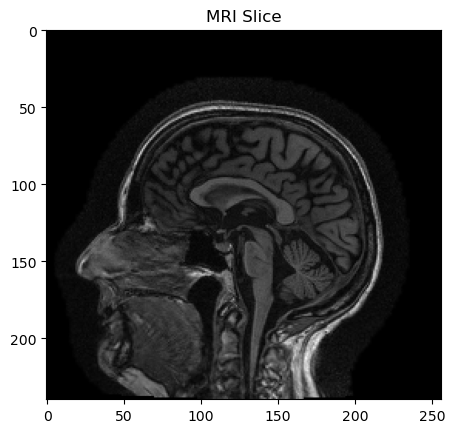

In [3]:
# Function to load and visualize an MRI scan
def load_and_visualize_nifti(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    
    # Print the shape of the data
    print(f"Image shape: {img.shape}")
    print(f"Image Affine: {img.affine}")
    
    # Visualize a slice of the MRI
    slice_index = data.shape[2] // 2  # Taking a middle slice for visualization
    plt.imshow(data[:, :, slice_index], cmap='gray')
    plt.title('MRI Slice')
    plt.show()
    
    return img, data

# Example usage
# file_path = '/Volumes/ZX20/Masters/Dissertation/ADNI_2/002_S_0413/MPR____N3__Scaled/2006-05-19_16_17_47.0/I40657/ADNI_002_S_0413_MR_MPR____N3__Scaled_Br_20070216232854688_S14782_I40657.nii'
img, data = load_and_visualize_nifti(file_path)

Given the original image shape and affine matrix, it appears that the original affine matrix already defines a proper orientation and scaling for the image. Resampling might not be necessary unless you need to change the voxel size or align the image with a specific template.

## Step 2: Skull Stripping using FSL’s BET

In [4]:
# Set FSL environment variables
os.environ['FSLDIR'] = '/Users/mohidaligill/Documents/Alzheimers/fsl'  # Update this path to your FSL installation directory
os.environ['FSLOUTPUTTYPE'] = 'NIFTI_GZ'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'share/fsl/bin')

# Verify the BET path
bet_path = os.path.join(os.environ['FSLDIR'], 'bin', 'bet')

# Ensure the output directory exists
output_dir = '/Users/mohidaligill/Documents/Alzheimers/outputs'
os.makedirs(output_dir, exist_ok=True)

# Function to perform skull stripping using FSL's BET with the full path
def skull_strip(file_path, output_path, bet_path=bet_path):
    result = subprocess.run([bet_path, file_path, output_path, '-R'], capture_output=True, text=True)
    
    # Check for common errors in stderr
    if 'error' in result.stderr.lower() or not os.path.exists(output_path):
        raise FileNotFoundError(f"Skull stripped file not found: {output_path}\nError message: {result.stderr}")

Image shape: (240, 256, 160)
Image Affine: [[ 0.00000000e+00 -5.90971597e-09 -1.20392406e+00  9.59803085e+01]
 [-6.00273134e-09 -9.90948021e-01  7.17984101e-09  1.31561630e+02]
 [-1.00654495e+00  5.90971597e-09  0.00000000e+00  1.01998550e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


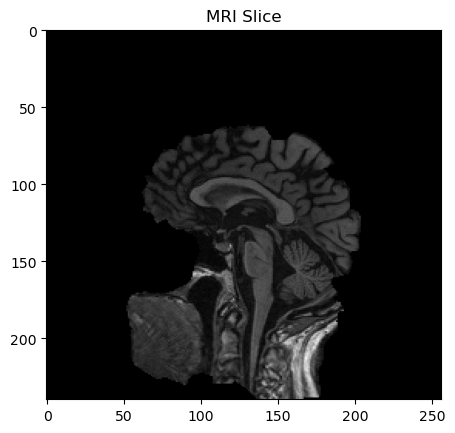

In [5]:
skull_stripped_path = '/Users/mohidaligill/Documents/Alzheimers/outputs/skull_stripped.nii.gz'
skull_strip(file_path, skull_stripped_path, bet_path)
skull_stripped_img, skull_stripped_data = load_and_visualize_nifti(skull_stripped_path)

## Step 3: Intensity Normalization

Intensity normalization adjusts the intensity values of the MRI scan so that they fall within a standard range, typically 0 to 1. This can help improve the consistency and performance of subsequent analysis or machine learning models.

In [6]:
# Function to normalize MRI data
def normalize_intensity(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

## Step 4: Bias Field Correction

What is Bias Field Correction?

Bias field correction is a preprocessing step used to address the intensity inhomogeneity problem in MRI images. Intensity inhomogeneity, or bias field, is a low-frequency, spatially varying artifact that affects MRI images. It can cause the same tissue to appear with different intensities in different parts of the image, which can complicate image analysis and processing.

Why Does Bias Field Occur?

The bias field artifact is caused by various factors:

	1.	Magnetic Field Inhomogeneity: Imperfections in the MRI scanner’s magnetic field.
	2.	RF Coil Inhomogeneity: Variations in the sensitivity of the radiofrequency (RF) coils used in the MRI scanner.
	3.	Patient-Induced Artifacts: Variations in the patient’s position and tissue properties.

Why is Bias Field Correction Important?

	•	Improves Consistency: Ensures that the intensity of the same tissue is consistent across the entire image.
	•	Enhances Image Quality: Reduces artifacts and improves the overall quality of the image.
	•	Facilitates Analysis: Makes subsequent analysis steps, such as segmentation and registration, more accurate and reliable.

How is Bias Field Correction Performed?

Bias field correction is typically performed using algorithms that model and remove the bias field. One of the most widely used methods is the N4ITK (N4 Bias Field Correction), which is implemented in the SimpleITK library.

N4ITK Bias Field Correction

N4ITK is a robust and widely used algorithm for bias field correction. It estimates the bias field using an iterative process and corrects the image by dividing it by the estimated bias field.

In [7]:
# Function to perform bias field correction using N4ITK
def bias_field_correction(file_path, output_path):
    image = sitk.ReadImage(file_path)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected_image = corrector.Execute(image)
    sitk.WriteImage(corrected_image, output_path)
    if not os.path.exists(output_path):
        raise FileNotFoundError(f"Bias field corrected file not found: {output_path}")

In [ ]:
# Example usage
bias_corrected_path = os.path.join(output_dir, 'bias_corrected.nii.gz')
bias_field_correction(normalised_img_path, bias_corrected_path)

bias_corrected_img, bias_corrected_data = load_and_visualize_nifti(bias_corrected_path)

## Step 5: Registration to Template

What is Image Registration?

Image registration is the process of transforming different sets of data into one coordinate system. In the context of MRI images, registration aligns images to a common template or anatomical space. This is crucial for consistent analysis and comparison across different subjects or within the same subject over time.

Why is Registration Needed?

	1.	Standardization: Aligns individual MRI scans to a common anatomical space, facilitating comparison across subjects.
	2.	Analysis Consistency: Ensures that anatomical structures correspond to the same coordinates in all images, which is essential for statistical analysis and group studies.
	3.	Improved Accuracy: Enhances the accuracy of subsequent processing steps like segmentation, statistical analysis, and machine learning.

Types of Registration

	•	Linear Registration: Applies transformations like translation, rotation, scaling, and shearing. It is used for global alignment.
	•	Nonlinear Registration: Applies more complex deformations to account for local anatomical variations. It is used for finer alignment and better anatomical correspondence.

The MNI152 Template

The MNI152 template is a standard brain template used in neuroimaging. It is created by averaging the MRI scans of 152 normal adult subjects, aligned to the MNI (Montreal Neurological Institute) coordinate system. The template represents a standard anatomical space that facilitates comparison across studies.

Why Use the MNI152 Template?

	1.	Standard Anatomical Space: Provides a common reference for aligning individual MRI scans.
	2.	Widely Used: Facilitates comparison and reproducibility across different studies and research groups.
	3.	Anatomically Consistent: Represents an average brain, reducing the impact of individual anatomical variability.

Registration with ANTs

Advanced Normalization Tools (ANTs) is a suite of tools for image processing, particularly well-regarded for its robust and accurate image registration capabilities.

We’ll use ANTs (Advanced Normalization Tools) to perform the registration. ANTs provides robust and accurate tools for image registration.

In [5]:
# Function to register an MRI scan to a template image using ANTsPy
def register_to_template(moving_image_path, fixed_image_path, output_prefix):
    fixed = ants.image_read(fixed_image_path)
    moving = ants.image_read(moving_image_path)
    registration = ants.registration(fixed=fixed, moving=moving, type_of_transform='SyN')
    warped_image = registration['warpedmovout']
    warped_image_path = output_prefix + 'warped.nii.gz'
    ants.image_write(warped_image, warped_image_path)
    return warped_image_path

Image shape: (182, 218, 182)
Image Affine: [[  -1.   -0.    0.   90.]
 [  -0.    1.   -0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]


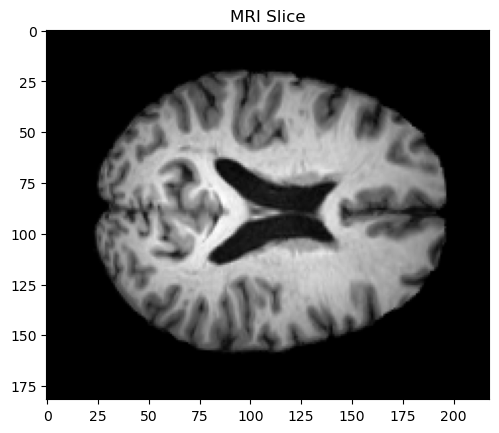

In [9]:
# Example usage
template_path = '/Users/mohidaligill/Documents/Alzheimers/MNI152_T1_1mm_brain.nii.gz'  # Path to the downloaded MNI152 template
output_prefix = '/Users/mohidaligill/Documents/Alzheimers/outputs/transform_'
cropped_img_path = '/Users/mohidaligill/Documents/Alzheimers/outputs/bias_corrected.nii.gz'
warped_image_path = register_to_template(cropped_img_path, template_path, output_prefix)

registered_img, registered_data = load_and_visualize_nifti(warped_image_path)

## Pre processing all Images

In [6]:
def process_all_mri_images(adni_folder, output_folder, template_path, bet_path):
    for patient_id in os.listdir(adni_folder):
        patient_path = os.path.join(adni_folder, patient_id)
        if not os.path.isdir(patient_path):
            continue
        
        # Get the list of folders within the patient's directory
        patient_subfolders = [f for f in os.listdir(patient_path) if os.path.isdir(os.path.join(patient_path, f))]
        if not patient_subfolders:
            continue
        
        # Iterate through all subfolders
        for patient_folder_name in patient_subfolders:
            patient_folder = os.path.join(patient_path, patient_folder_name)
            
            for date_folder in os.listdir(patient_folder):
                date_folder_path = os.path.join(patient_folder, date_folder)
                if not os.path.isdir(date_folder_path):
                    continue
                
                for image_data_id in os.listdir(date_folder_path):
                    image_data_path = os.path.join(date_folder_path, image_data_id)
                    if not os.path.isdir(image_data_path):
                        continue
                    
                    for mri_image in os.listdir(image_data_path):
                        mri_path = os.path.join(image_data_path, mri_image)
                        if not os.path.isfile(mri_path):
                            continue
                        
                        # Step 4: Check if the final image from registration already exists
                        output_prefix = os.path.join(output_folder, f"final/{patient_id}_{date_folder}_{image_data_id}_{mri_image}_")
                        warped_image_path = output_prefix + "warped.nii.gz"
                        if os.path.exists(warped_image_path):
                            continue  # Skip this image if the final output already exists

                        # Step 1: Skull Stripping
                        skull_stripped_path = os.path.join(output_folder, f"{patient_id}_{date_folder}_{image_data_id}_{mri_image}_skull_stripped.nii.gz")
                        skull_strip(mri_path, skull_stripped_path, bet_path)
                        
                        # Step 2: Intensity Normalization
                        skull_stripped_img = nib.load(skull_stripped_path)
                        skull_stripped_data = skull_stripped_img.get_fdata()
                        normalized_data = normalize_intensity(skull_stripped_data)
                        normalized_img = nib.Nifti1Image(normalized_data, skull_stripped_img.affine)
                        normalized_path = os.path.join(output_folder, f"{patient_id}_{date_folder}_{image_data_id}_{mri_image}_normalized.nii.gz")
                        nib.save(normalized_img, normalized_path)
                        
                        # Step 3: Bias Field Correction
                        bias_corrected_path = os.path.join(output_folder, f"{patient_id}_{date_folder}_{image_data_id}_{mri_image}_bias_corrected.nii.gz")
                        bias_field_correction(normalized_path, bias_corrected_path)
                        
                        # Step 4: Image Registration
                        warped_image_path = register_to_template(bias_corrected_path, template_path, output_prefix)

In [7]:
# Parameters
adni_folder = '/Users/mohidaligill/Documents/Alzheimers/ADNI'  # Replace with the path to your ADNI folder
output_folder = '/Volumes/ZX20/outputs'  # Replace with the path to your output folder
template_path = '/Users/mohidaligill/Documents/Alzheimers/fsl/pkgs/fsl-data_standard-2208.0-0/data/standard/MNI152_T1_1mm_brain.nii.gz'  # Path to the template
# Verify the BET path
bet_path = os.path.join(os.environ['FSLDIR'], 'bin', 'bet')

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_folder + '/final', exist_ok=True)

In [8]:
process_all_mri_images(adni_folder, output_folder, template_path, bet_path)

## Segmentation

Atlas-based segmentation is a powerful method to segment specific brain regions by aligning the subject’s MRI scans to a labeled brain atlas. The labeled atlas contains predefined regions of interest (ROIs) that can be mapped onto the subject’s brain to extract regions like the hippocampus, amygdala, and others

Steps for Atlas-Based Segmentation

	1.	Choose an Atlas: Select a brain atlas that has the regions of interest (ROIs) labeled, such as the MNI atlas, Harvard-Oxford atlas, or AAL (Automated Anatomical Labeling) atlas.
	2.	Register the Subject’s MRI to the Atlas: Align the subject’s MRI to the atlas space using tools like ANTs or FSL.
	3.	Apply the Atlas Labels: Transfer the atlas labels to the subject’s MRI to segment the regions of interest.
	4.	Extract Segmented Regions: Use the labels to extract the segmented regions, such as the hippocampus or amygdala.
	5.	Evaluate and Refine: Assess the segmentation results and refine if necessary.

### Step 1: Load the Registered MRI and Atlas

In [9]:
# Load the registered MRI (already aligned to MNI152 space)
# registered_mri_path = '/Users/mohidaligill/Documents/Alzheimers/final/031_S_1066_2007-12-14_16_38_15.0_I87106_ADNI_031_S_1066_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20080111142901961_S44040_I87106.nii_warped.nii.gz'
registered_mri_path = '/Users/mohidaligill/Documents/Alzheimers/final/031_S_0830_2008-09-25_15_04_31.0_I124115_ADNI_031_S_0830_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20081027135813050_S56755_I124115.nii_warped.nii.gz'
registered_mri = nib.load(registered_mri_path)
data = registered_mri.get_fdata()

# Load the atlas that corresponds to MNI152 space (e.g., Harvard-Oxford Subcortical Atlas)
atlas_path = "/Users/mohidaligill/Documents/Alzheimers/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz"
atlas_img = ants.nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

FileNotFoundError: No such file or no access: '/Users/mohidaligill/Documents/Alzheimers/final/031_S_0830_2008-09-25_15_04_31.0_I124115_ADNI_031_S_0830_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20081027135813050_S56755_I124115.nii_warped.nii.gz'

### Step 2: Apply the Atlas to Your Registered MRI

In [ ]:
# Labels for left and right hippocampus (adjust these labels based on the atlas)
hippocampus_labels = [9, 19]

# Create a binary mask for the hippocampus
hippocampus_mask = np.isin(atlas_data, hippocampus_labels).astype(np.float32)

# Convert the mask to a Nifti image
hippocampus_mask_img = nib.Nifti1Image(hippocampus_mask, atlas_img.affine)

# Resample the mask to the MRI image's space
resampled_mask_img = image.resample_to_img(hippocampus_mask_img, img, interpolation='nearest')

# Apply the mask to the MRI image to extract the hippocampus
hippocampus_data = image.math_img("img1 * img2", img1=img, img2=resampled_mask_img)

# Save the segmented hippocampus
hippocampus_img = nib.Nifti1Image(hippocampus_data.get_fdata(), img.affine)
nib.save(hippocampus_img, 'hippocampus_segmented1.nii.gz')

### Step 3: Visualize the Segmentation Results

In [ ]:
plotting.plot_stat_map(hippocampus_img, bg_img=img, title="Segmented Hippocampus")
plotting.show()

### Step 4: Extract Specific Brain Regions

When predicting Alzheimer’s disease using segmented brain regions, different regions provide different types of information that could be indicative of the disease’s progression. The hippocampus is the most studied, but other regions can also provide valuable insights. Here’s an overview of potential features you can extract from each of the segmented regions you listed and their relevance to Alzheimer’s prediction:

1. Hippocampus (Left and Right)

	•	Volume: Reduced volume is strongly associated with Alzheimer’s.
	•	Shape Descriptors: Changes in the shape of the hippocampus could indicate atrophy.
	•	Texture Features: Intensity-based features within the hippocampus might show differences in tissue integrity.

2. Amygdala (Left and Right)

	•	Volume: Like the hippocampus, the amygdala volume tends to decrease in Alzheimer’s patients.
	•	Shape Descriptors: Shape changes in the amygdala may be another sign of disease progression.

3. Cerebral Cortex (Left and Right)

	•	Cortical Thickness: Thinning of the cortex, especially in the temporal and parietal lobes, is associated with Alzheimer’s.
	•	Surface Area: A reduction in cortical surface area can also be indicative of neurodegeneration.
	•	Gyrification Index: Changes in the folding patterns of the cortex may be relevant.

4. Thalamus (Left and Right)

	•	Volume: Atrophy in the thalamus is less pronounced but still relevant in advanced stages of Alzheimer’s.
	•	Connectivity Patterns: While more advanced, examining functional or structural connectivity involving the thalamus might provide additional insights.

5. Caudate (Left and Right)

	•	Volume: Atrophy in the caudate has been observed in some Alzheimer’s patients.
	•	Shape Descriptors: Changes in the shape of the caudate could also be relevant.

6. Lateral Ventricles (Left and Right)

	•	Ventricular Volume: Enlargement of the lateral ventricles is often associated with general brain atrophy and is a common feature in Alzheimer’s.
	•	Shape Descriptors: Changes in the shape of the ventricles can indicate specific patterns of brain atrophy.

Features Summary

	•	Volume: Almost all brain regions can provide useful volume information. Atrophy in specific areas is a hallmark of Alzheimer’s disease.
	•	Shape Descriptors: The shape of brain structures may change due to atrophy, and these changes can be captured using various shape descriptors (e.g., surface area, curvature).
	•	Cortical Thickness: Specifically for the cerebral cortex, cortical thickness is a critical feature, especially in regions like the temporal and parietal lobes.
	•	Texture and Intensity: These features can be extracted from the hippocampus, amygdala, and possibly other regions to capture changes in tissue integrity.

Most Impactful Features for Alzheimer’s Prediction

Based on research and clinical practice, the most impactful features for predicting Alzheimer’s are typically:

	1.	Hippocampus Volume and Shape: The strongest single predictor of Alzheimer’s.
	2.	Amygdala Volume: Important, especially in later stages.
	3.	Cortical Thickness: Particularly in the temporal, parietal, and frontal lobes.
	4.	Ventricular Volume: Enlargement correlates with general brain atrophy.

In [50]:
labels = {
    "left_hippocampus": 9,
    "right_hippocampus": 19,
    "left_amygdala": 10,
    "right_amygdala": 20,
    "left_cortex": 2,
    "right_cortex": 13,
    "left_lateral_ventricle": 3,
    "right_lateral_ventricle": 14
}

def segment_images(images_dir, atlas_path, output_dir):
    count = 0
    files = os.listdir(images_dir)
    for file in files:
        # Only process .nii.gz files
        if file.endswith('.nii.gz'):
            count += 1
            registered_mri_path = os.path.join(images_dir, file) 
            registered_mri = nib.load(registered_mri_path)
            registered_mri_data = registered_mri.get_fdata()
        
            atlas_img = nib.load(atlas_path)
            atlas_data = atlas_img.get_fdata()
            
            stripped_file_name = file.replace('.nii_warped.nii.gz', '')
            
            for label in labels:
                label_out_path = f"{output_dir}/segmented/{stripped_file_name}_{label}.nii.gz"
                label_mask = np.isin(atlas_data, labels[label]).astype(np.float32)
                label_mask_img = nib.Nifti1Image(label_mask, atlas_img.affine)
                
                resampled_mask_img = image.resample_to_img(label_mask_img, registered_mri, interpolation='nearest')
                label_data = image.math_img("img1 * img2", img1=registered_mri, img2=resampled_mask_img)
                label_img = nib.Nifti1Image(label_data.get_fdata(), registered_mri.affine)
                
                nib.save(label_img, label_out_path)
    print(count)

In [51]:
def segment_images_combined(images_dir, atlas_path, output_dir):
    count = 0
    files = os.listdir(images_dir)
    
    for file in files:
        count += 1
        registered_mri_path = os.path.join(images_dir, file)
        registered_mri = nib.load(registered_mri_path)
        registered_mri_data = registered_mri.get_fdata()
        
        atlas_img = nib.load(atlas_path)
        atlas_data = atlas_img.get_fdata()
        
        stripped_file_name = file.replace('.nii_warped.nii.gz', '')
        
        # Create an empty array with the same shape as the MRI data to hold the combined labels
        combined_labels = np.zeros(atlas_data.shape, dtype=np.float32)
        
        for label_name, label_value in labels.items():
            label_mask = np.isin(atlas_data, label_value).astype(np.float32)
            label_mask_img = nib.Nifti1Image(label_mask, atlas_img.affine)
            
            # Resample the label mask to match the MRI data dimensions
            resampled_mask_img = image.resample_to_img(label_mask_img, registered_mri, interpolation='nearest')
            
            # Add the label value to the combined_labels array where the mask is true
            combined_labels[resampled_mask_img.get_fdata() > 0] = label_value
        
        # Create a new NIfTI image with the combined labels
        combined_labels_img = nib.Nifti1Image(combined_labels, registered_mri.affine)
        
        # Save the combined labels image as a single NIfTI file
        combined_label_out_path = f"{output_dir}/segmented_1/{stripped_file_name}_combined_labels.nii.gz"
        nib.save(combined_labels_img, combined_label_out_path)
    
    print(f"Processed {count} files")

In [18]:
import os
import nibabel as nib
import numpy as np
from nilearn import image

labels = {
    "left_hippocampus": 9,
    "right_hippocampus": 19,
    "left_amygdala": 10,
    "right_amygdala": 20,
    "left_cortex": 2,
    "right_cortex": 13,
    "left_lateral_ventricle": 3,
    "right_lateral_ventricle": 14
}

def segment_images_combined(images_dir, atlas_path, output_dir):
    count = 0
    files = os.listdir(images_dir)
    
    for file in files:
        count += 1
        registered_mri_path = os.path.join(images_dir, file)
        registered_mri = nib.load(registered_mri_path)
        registered_mri_data = registered_mri.get_fdata()
        
        atlas_img = nib.load(atlas_path)
        atlas_data = atlas_img.get_fdata()
        
        stripped_file_name = file.replace('.nii_warped.nii.gz', '')
        
        # Create an empty array with the same shape as the MRI data to hold the combined labels
        combined_labels = np.zeros(atlas_data.shape, dtype=np.float32)
        
        for label_name, label_value in labels.items():
            # Get the mask for the current label
            label_mask = (atlas_data == label_value).astype(np.float32)
            
            # Create a NIfTI image for the label mask
            label_mask_img = nib.Nifti1Image(label_mask, atlas_img.affine)
            
            # Resample the label mask to match the MRI data dimensions
            resampled_mask_img = image.resample_to_img(label_mask_img, registered_mri, interpolation='nearest')
            
            # Add the label value to the combined_labels array where the mask is true
            resampled_mask_data = resampled_mask_img.get_fdata()
            combined_labels[resampled_mask_data > 0] = label_value
        
        # Create a new NIfTI image with the combined labels (single-channel)
        combined_labels_img = nib.Nifti1Image(combined_labels, registered_mri.affine)
        
        # Save the combined labels image as a single NIfTI file
        combined_label_out_path = f"{output_dir}/segmented_2/{stripped_file_name}_combined_labels.nii.gz"
        nib.save(combined_labels_img, combined_label_out_path)
    
    print(f"Processed {count} files")

In [20]:
images_dir = '/Volumes/ZX20/Masters/Dissertation/outputs/final'
atlas_path = '/Users/mohidaligill/Documents/Alzheimers/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz'
output_dir = '/Volumes/ZX20/Masters/Dissertation'

# segment_images(images_dir, atlas_path, output_dir)
segment_images_combined(images_dir, atlas_path, output_dir)

Processed 543 files


In [29]:
def rename_segmented_files(segmented_dir):
    # List all files in the directory
    files = os.listdir(segmented_dir)

    # Regular expression to match the MRI number and brain part
    pattern = re.compile(r'(I\d{5,6})')

    # Process each file in the directory
    for file in files:
        # Check if the file is a .nii.gz file
        if not file.endswith('.nii.gz'):
            continue

        # Attempt to match the file with the regular expression
        match = pattern.search(file)
        if match:
            # Extract MRI number and brain part
            mri_number = match.group(1)

            # Construct the new file name
            new_file_name = f"{mri_number}.nii.gz"

            # Full old and new file paths
            old_file_path = os.path.join(segmented_dir, file)
            new_file_path = os.path.join(segmented_dir, new_file_name)

            # Rename the file
            os.rename(old_file_path, new_file_path)

# Example usage:
rename_segmented_files('/Volumes/ZX20/Masters/Dissertation/segmented_2')

In [ ]:
def rename_segmented_files(segmented_dir):
    # List all files in the directory
    files = os.listdir(segmented_dir)

    # Regular expression to match the MRI number and brain part
    pattern = re.compile(r'(I\d{5,6})_.*_(left|right)_(amygdala|cortex|hippocampus|lateral_ventricle)')

    # Process each file in the directory
    for file in files:
        # Check if the file is a .nii.gz file
        if not file.endswith('.nii.gz'):
            continue

        # Attempt to match the file with the regular expression
        match = pattern.search(file)
        if match:
            # Extract MRI number and brain part
            mri_number = match.group(1)
            brain_part = f"{match.group(2)}_{match.group(3)}"

            # Construct the new file name
            new_file_name = f"{mri_number}_{brain_part}.nii.gz"

            # Full old and new file paths
            old_file_path = os.path.join(segmented_dir, file)
            new_file_path = os.path.join(segmented_dir, new_file_name)

            # Rename the file
            os.rename(old_file_path, new_file_path)

# Example usage:
rename_segmented_files('/Volumes/ZX20/segmented')

## Feature Extraction

	•	Left Hippocampus: Volume, Compactness, Surface Area.
	•	Right Hippocampus: Volume, Compactness, Surface Area.
	•	Left Amygdala: Volume, Sphericity.
	•	Right Amygdala: Volume, Sphericity.
	•	Left Cortex: Volume, Surface Area, Convexity.
	•	Right Cortex: Volume, Surface Area, Convexity.
	•	Left Ventricle: Volume, Eccentricity.
	•	Right Ventricle: Volume, Eccentricity.

In [16]:
def extract_volume(segmented_image_path):
    segmented_img = nib.load(segmented_image_path)
    segmented_data = segmented_img.get_fdata()
    volume_voxels = np.sum(segmented_data)  # Volume in voxels
    voxel_volume = np.prod(segmented_img.header.get_zooms())  # Voxel size in mm³
    return volume_voxels * voxel_volume  # Volume in mm³

def extract_surface_area(segmented_image_path):
    segmented_img = nib.load(segmented_image_path)
    segmented_data = segmented_img.get_fdata()
    
    # Surface area using marching cubes (3D surface extraction)
    verts, faces, _, _ = measure.marching_cubes(segmented_data, level=0)
    surface_area = measure.mesh_surface_area(verts, faces)
    
    return surface_area  # Surface area in mm²

def extract_compactness(volume, surface_area):
    if volume == 0:
        return 0
    return surface_area**2 / volume  # Compactness

def extract_sphericity(volume, surface_area):
    if surface_area == 0:
        return 0
    return (np.pi**(1/3)) * (6 * volume)**(2/3) / surface_area  # Sphericity

def extract_eccentricity(segmented_image_path):
    segmented_img = nib.load(segmented_image_path)
    segmented_data = segmented_img.get_fdata()
    
    moments = measure.moments_central(segmented_data)
    cov = np.cov(np.array(np.nonzero(segmented_data)))
    evals, _ = np.linalg.eigh(cov)
    
    if evals.max() == 0:
        return 0
    return np.sqrt(1 - evals.min() / evals.max())  # Eccentricity

### Extract features from all images

In [17]:
def extract_features_from_segmented_images(segmented_dir, output_csv_path):
    # List all files in the directory
    files = os.listdir(segmented_dir)

    # Initialize a dictionary to store features for each MRI_ID
    features_dict = {}

    # Process each file in the directory
    for file in files:
        if not file.endswith('.nii.gz'):
            continue
        
        # Extract the MRI ID and the part name from the filename
        mri_id, part_name = file.split('_', 1)
        part_name = part_name.replace('.nii.gz', '')
        
        # Construct the full file path
        image_path = os.path.join(segmented_dir, file)
        
        if os.path.exists(image_path):
            # Extract volume
            volume = extract_volume(image_path)
            
            # Extract surface area
            surface_area = extract_surface_area(image_path)
            
            # Extract shape descriptors
            compactness = extract_compactness(volume, surface_area)
            sphericity = extract_sphericity(volume, surface_area)
            eccentricity = extract_eccentricity(image_path)
            
            # If the MRI_ID is not yet in the dictionary, add it
            if mri_id not in features_dict:
                features_dict[mri_id] = {}

            # Add the features for this brain part to the dictionary
            features_dict[mri_id][f"{part_name}_Volume_mm3"] = volume
            features_dict[mri_id][f"{part_name}_Surface_Area_mm2"] = surface_area
            features_dict[mri_id][f"{part_name}_Compactness"] = compactness
            features_dict[mri_id][f"{part_name}_Sphericity"] = sphericity
            features_dict[mri_id][f"{part_name}_Eccentricity"] = eccentricity

    # Convert the dictionary to a DataFrame
    features_df = pd.DataFrame.from_dict(features_dict, orient='index').reset_index()
    features_df.rename(columns={'index': 'MRI_ID'}, inplace=True)

    # Save the features to a CSV file
    features_df.to_csv(output_csv_path, index=False)

    # Display the DataFrame
    print("Features extracted and saved to:", output_csv_path)

In [46]:
def extract_features_from_segmented_images(segmented_dir, output_csv_path):
    # List all files in the directory
    files = os.listdir(segmented_dir)

    # Initialize a dictionary to store features for each MRI_ID
    features_dict = {}

    # Process each file in the directory
    for file in files:
        if not file.endswith('.nii.gz'):
            continue
        
        # Extract the MRI ID and the part name from the filename
        mri_id, part_name = file.split('_', 1)
        part_name = part_name.replace('.nii.gz', '')
        
        # Construct the full file path
        image_path = os.path.join(segmented_dir, file)
        
        if os.path.exists(image_path):
            try:
                # Extract volume
                volume = extract_volume(image_path)
                
                # Extract surface area
                surface_area = extract_surface_area(image_path)
                
                # Extract shape descriptors
                compactness = extract_compactness(volume, surface_area)
                sphericity = extract_sphericity(volume, surface_area)
                eccentricity = extract_eccentricity(image_path)
                
                # If the MRI_ID is not yet in the dictionary, add it
                if mri_id not in features_dict:
                    features_dict[mri_id] = {}

                # Add the features for this brain part to the dictionary
                features_dict[mri_id][f"{part_name}_Volume_mm3"] = volume
                features_dict[mri_id][f"{part_name}_Surface_Area_mm2"] = surface_area
                features_dict[mri_id][f"{part_name}_Compactness"] = compactness
                features_dict[mri_id][f"{part_name}_Sphericity"] = sphericity
                features_dict[mri_id][f"{part_name}_Eccentricity"] = eccentricity
            
            except Exception as e:
                # Print the file path and error if an error occurs
                print(f"Error processing file {image_path}: {e}")
                continue  # Skip to the next file

    # Convert the dictionary to a DataFrame
    features_df = pd.DataFrame.from_dict(features_dict, orient='index').reset_index()
    features_df.rename(columns={'index': 'MRI_ID'}, inplace=True)

    # Save the features to a CSV file
    features_df.to_csv(output_csv_path, index=False)

    # Display the DataFrame
    print("Features extracted and saved to:", output_csv_path)

In [19]:
segmented_dir = '/Volumes/ZX20/Masters/Dissertation/segmented'
output_csv_path = '/Users/mohidaligill/Documents/Alzheimers/features.csv'

extract_features_from_segmented_images(segmented_dir, output_csv_path)

Error processing file /Volumes/ZX20/Masters/Dissertation/segmented/I119735_left_amygdala.nii.gz: No surface found at the given iso value.
Error processing file /Volumes/ZX20/Masters/Dissertation/segmented/I119735_left_hippocampus.nii.gz: No surface found at the given iso value.
Error processing file /Volumes/ZX20/Masters/Dissertation/segmented/I119735_right_amygdala.nii.gz: No surface found at the given iso value.
Error processing file /Volumes/ZX20/Masters/Dissertation/segmented/I119735_right_hippocampus.nii.gz: No surface found at the given iso value.
Error processing file /Volumes/ZX20/Masters/Dissertation/segmented/I151369_right_amygdala.nii.gz: No surface found at the given iso value.
Error processing file /Volumes/ZX20/Masters/Dissertation/segmented/I151369_right_hippocampus.nii.gz: No surface found at the given iso value.
Error processing file /Volumes/ZX20/Masters/Dissertation/segmented/I40404_left_amygdala.nii.gz: No surface found at the given iso value.
Error processing file 

### Merging features

In [21]:
def remove_null_rows(input_file, output_file):
    # Load the CSV file
    df = pd.read_csv(input_file)
    
    # Get the number of rows before cleaning
    rows_before = df.shape[0]
    
    # Drop rows with any null values
    cleaned_df = df.dropna()
    
    # Get the number of rows after cleaning
    rows_after = cleaned_df.shape[0]
    
    # Calculate the number of rows deleted
    rows_deleted = rows_before - rows_after
    
    # Save the cleaned data to a new CSV file
    cleaned_df.to_csv(output_file, index=False)
    
    # Print the result
    print(f"Rows before cleaning: {rows_before}")
    print(f"Rows after cleaning: {rows_after}")
    print(f"Rows deleted: {rows_deleted}")


remove_null_rows('/Users/mohidaligill/Documents/Alzheimers/features.csv','/Users/mohidaligill/Documents/Alzheimers/features_cleaned.csv')

Rows before cleaning: 540
Rows after cleaning: 540
Rows deleted: 0


In [22]:
def merge_csv_files(features_csv, group_csv, output_csv):
    # Load the CSV files
    features_df = pd.read_csv(features_csv)
    group_df = pd.read_csv(group_csv)

    # Map Group labels to the numerical values as per your key
    group_mapping = {'CN': 0, 'MCI': 1, 'AD': 2}
    group_df['Group'] = group_df['Group'].map(group_mapping)

    # Merge the two dataframes on MRI_ID
    merged_df = pd.merge(features_df, group_df[['MRI_ID', 'Group']], on='MRI_ID', how='left')

    # Save the merged dataframe to a new CSV file
    merged_df.to_csv(output_csv, index=False)
    print(f"Merged CSV file saved to: {output_csv}")

# Example usage
csv_file_1 = '/Users/mohidaligill/Documents/Alzheimers/features_cleaned.csv'
csv_file_2 = '/Users/mohidaligill/Documents/Alzheimers/Label_File.csv'
output_file = '/Users/mohidaligill/Documents/Alzheimers/features_merged.csv'
merge_csv_files(csv_file_1, csv_file_2, output_file)

Merged CSV file saved to: /Users/mohidaligill/Documents/Alzheimers/features_merged.csv


## Exploratory Data Analysis


In [23]:
def plot_brain_part_features(csv_file, brain_part, graph_title, y_min=None, y_max=6000):
    # Load the CSV file
    data = pd.read_csv(csv_file)
    
    # Define the features we are interested in
    features = ['Volume_mm3', 'Surface_Area_mm2', 'Compactness', 'Sphericity', 'Eccentricity']
    
    # Define the color mapping and labels for each group
    color_mapping = {0: 'green', 1: 'orange', 2: 'red'}
    group_labels = {0: 'CN', 1: 'MCI', 2: 'AD'}
    
    # Group data by 'Group'
    groups = [0, 1, 2]
    
    # Iterate through each feature (e.g., Volume, Surface Area, etc.)
    for feature in features:
        # Dynamically generate column names for left and right parts
        left_feature_label = f'left_{brain_part}_{feature}'
        right_feature_label = f'right_{brain_part}_{feature}'
        
        # Calculate the average of the left and right feature
        data[f'average_{feature}'] = (data[left_feature_label] + data[right_feature_label]) / 2

        # Prepare data for boxplot
        box_data = [data[data['Group'] == group][f'average_{feature}'] for group in groups]
        
        # Create the boxplot
        plt.figure(figsize=(10, 6))
        box = plt.boxplot(box_data, patch_artist=True, labels=[group_labels[group] for group in groups])

        # Apply colors to the boxes
        colors = [color_mapping[group] for group in groups]
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
        
        # Add title and labels
        plt.title(f'{graph_title} - {feature}')
        plt.xlabel('Group')
        plt.ylabel(f'Average {feature}')
        
        # Set y-axis limits if provided
        if y_min is not None and y_max is not None:
            plt.ylim(y_min, y_max)

        # Add a grid for better readability
        plt.grid(True)

        # Display the plot
        plt.tight_layout()
        plt.show()

In [24]:
csv_file = '/Users/mohidaligill/Documents/Alzheimers/features_merged.csv'

### Data Balance

Class counts:
Group
1    265
0    177
2     98
Name: count, dtype: int64

Class percentages:
Group
1    49.074074
0    32.777778
2    18.148148
Name: count, dtype: float64


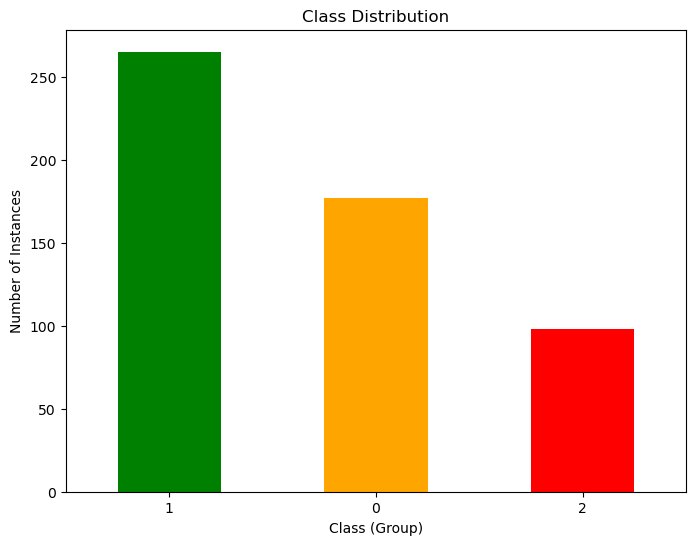

In [25]:
# Load the CSV data
data = pd.read_csv(csv_file)

# Count the occurrences of each class in the 'Group' column
class_counts = data['Group'].value_counts()

# Display the counts
print("Class counts:")
print(class_counts)

# Calculate the percentage of each class
class_percentages = class_counts / len(data) * 100
print("\nClass percentages:")
print(class_percentages)

# Plot the distribution of the classes
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class (Group)')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.show()

### Hippocampus Features

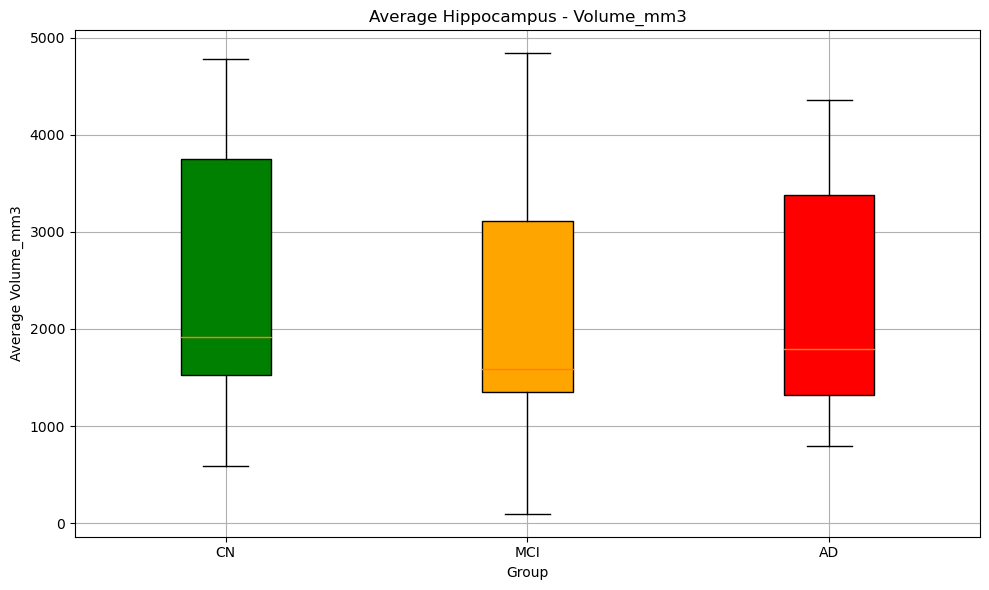

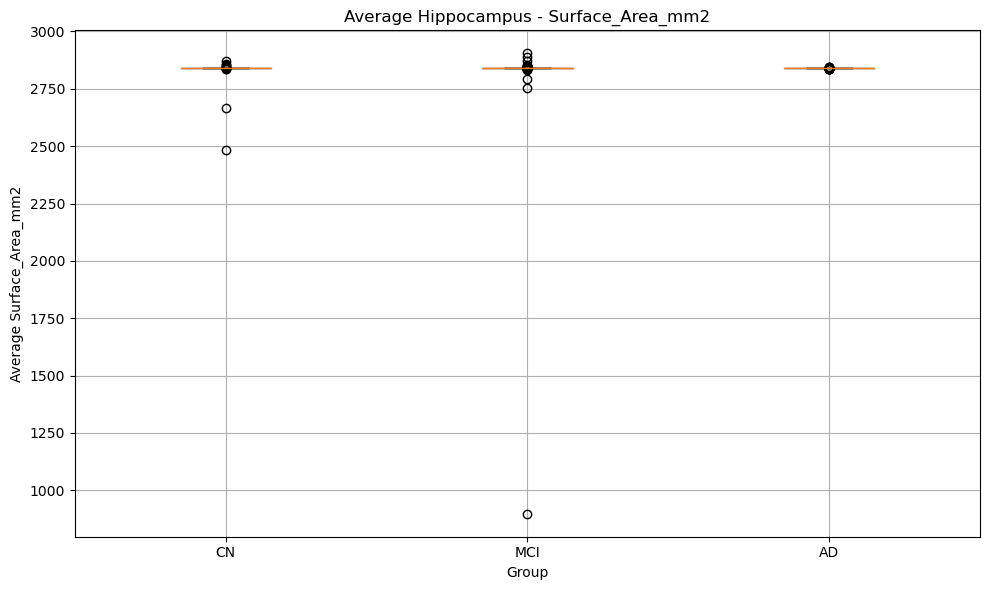

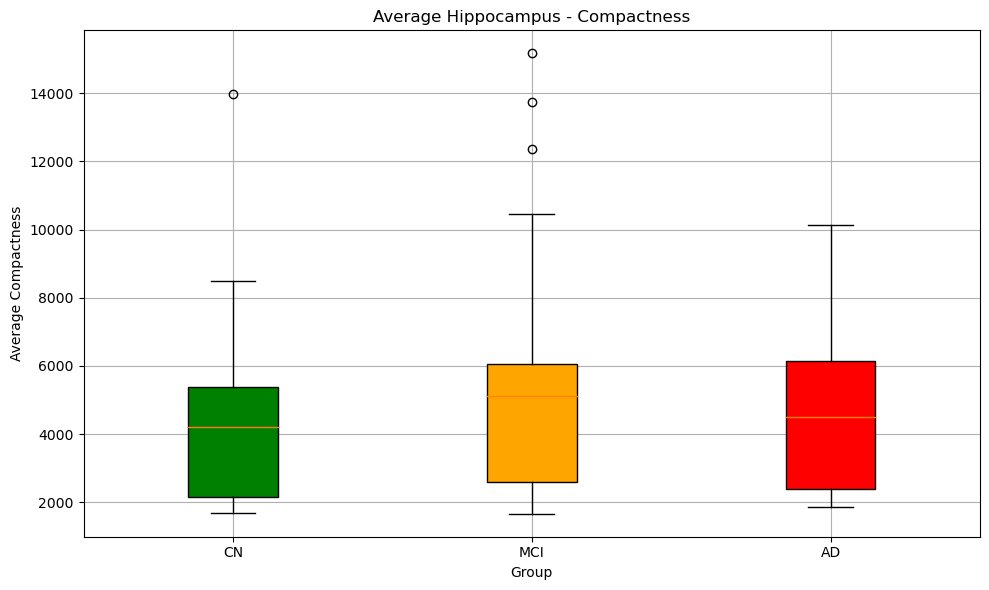

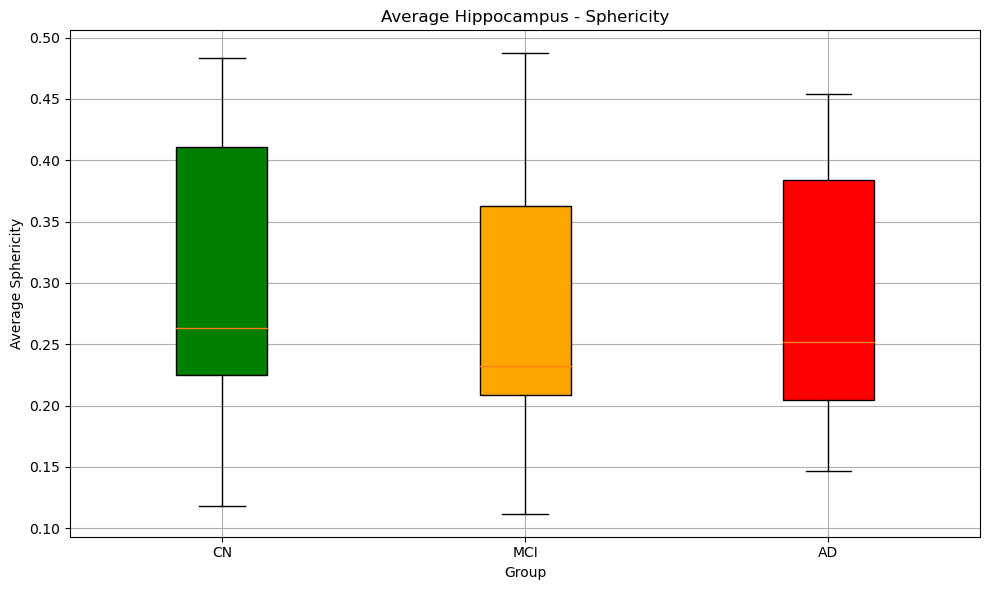

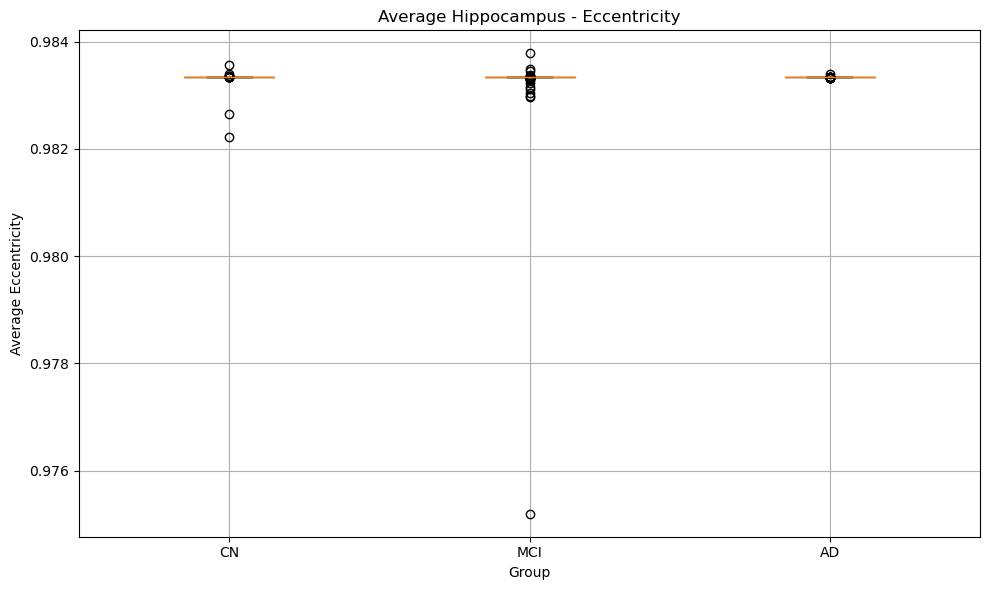

In [26]:
plot_brain_part_features(csv_file, 'hippocampus', 'Average Hippocampus')

### Cortex Features

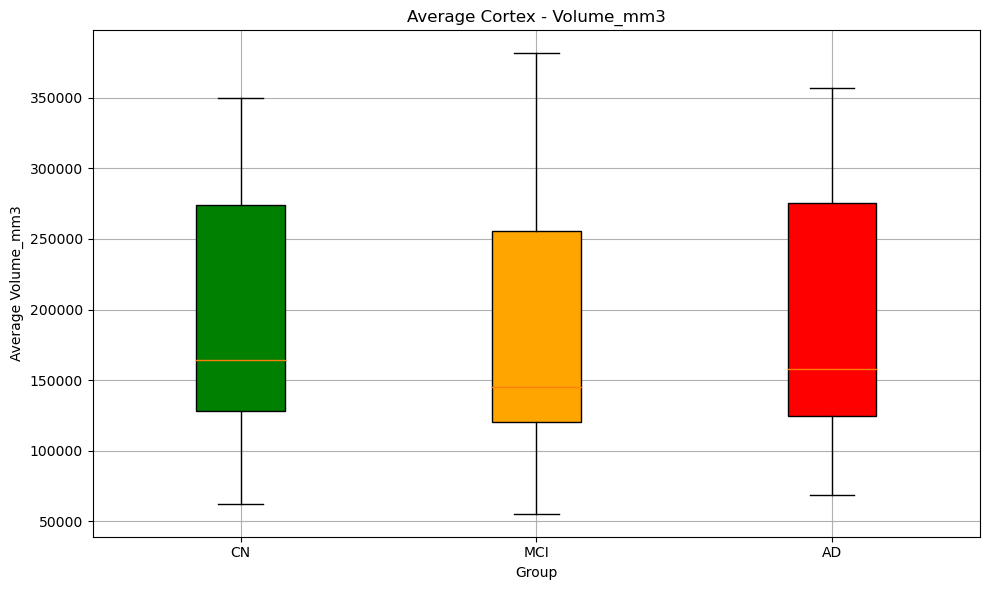

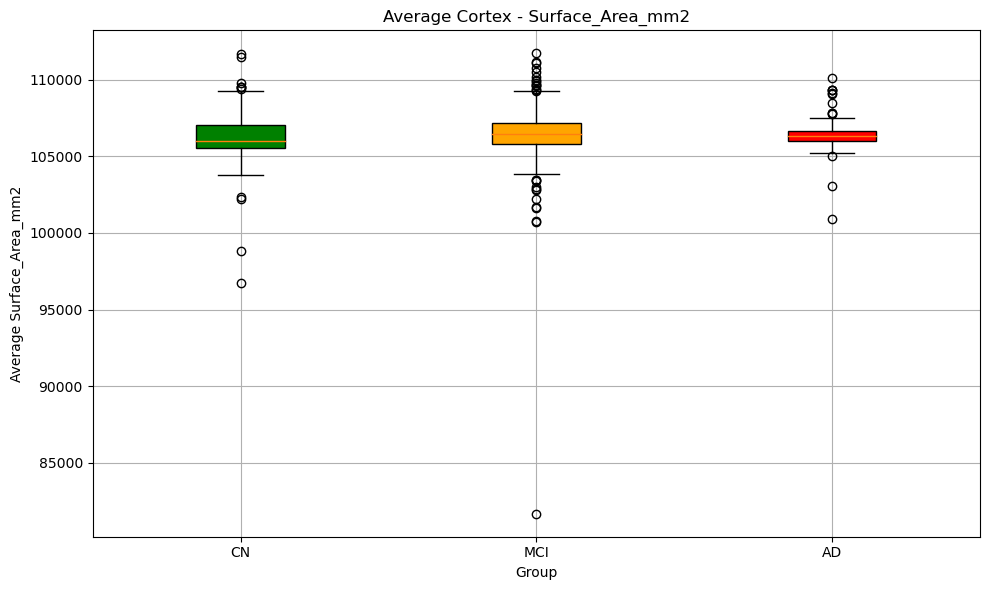

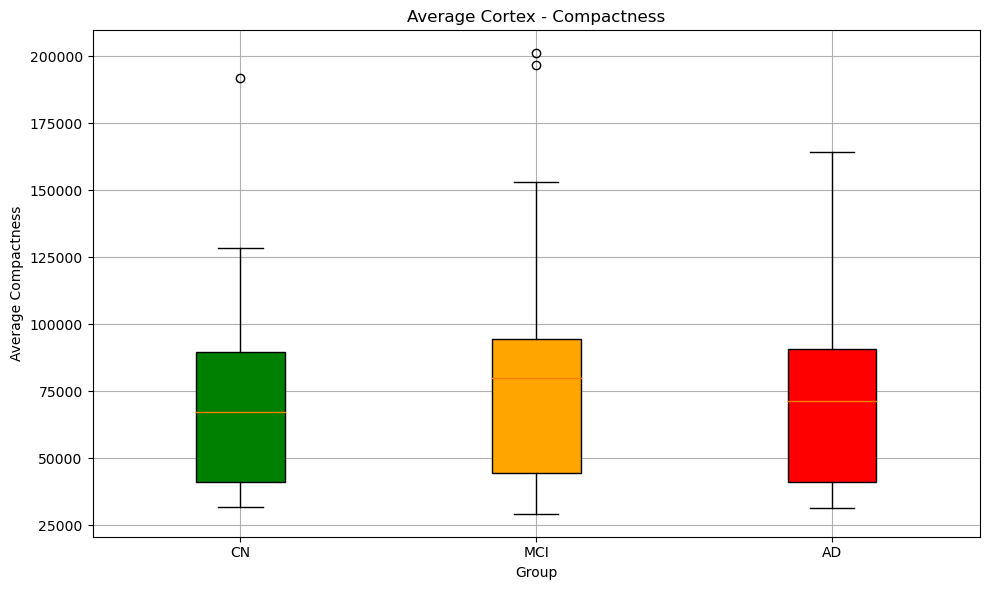

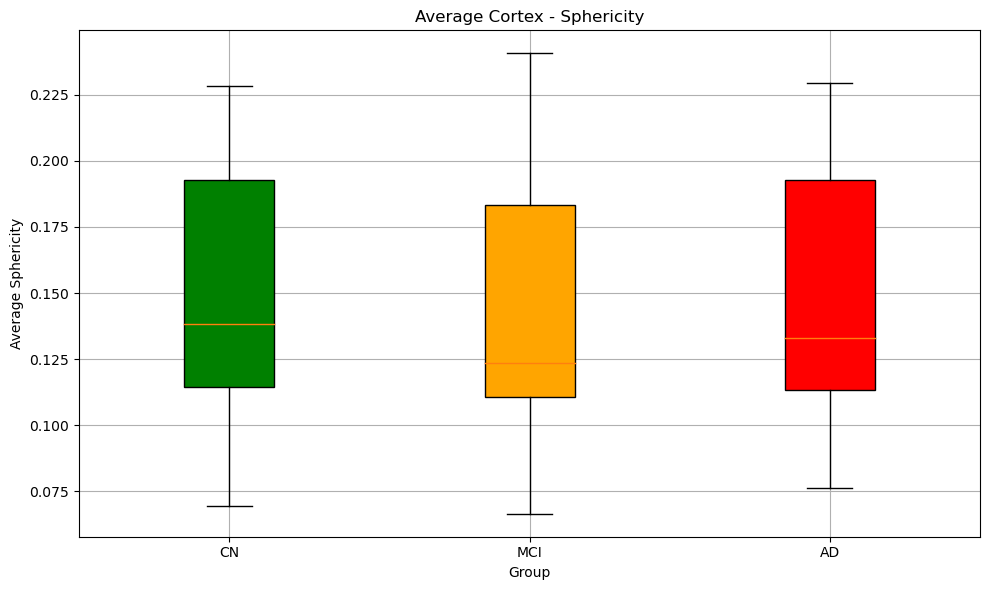

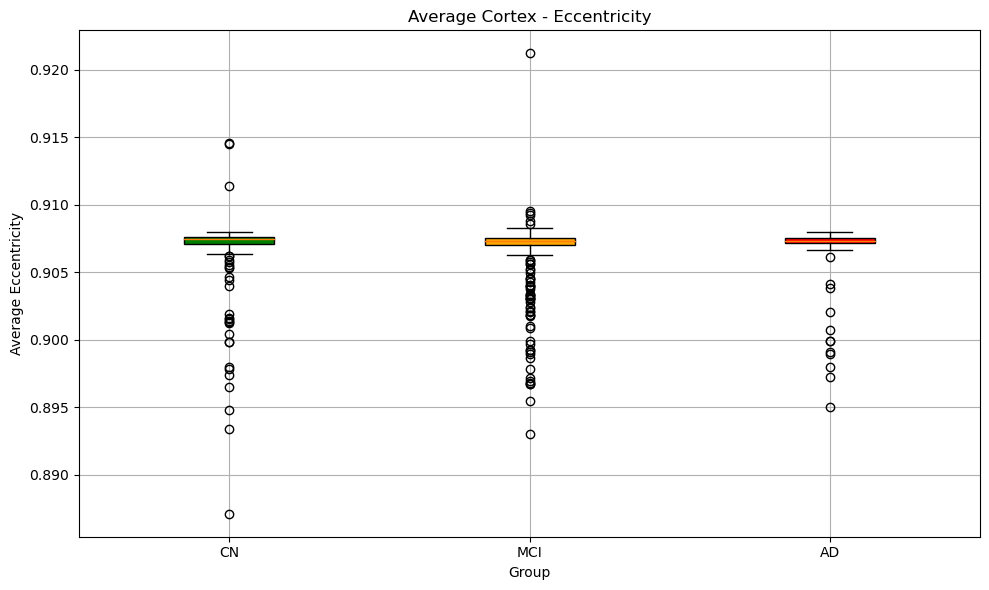

In [27]:
plot_brain_part_features(csv_file, 'cortex', 'Average Cortex')

### Amygdala Features

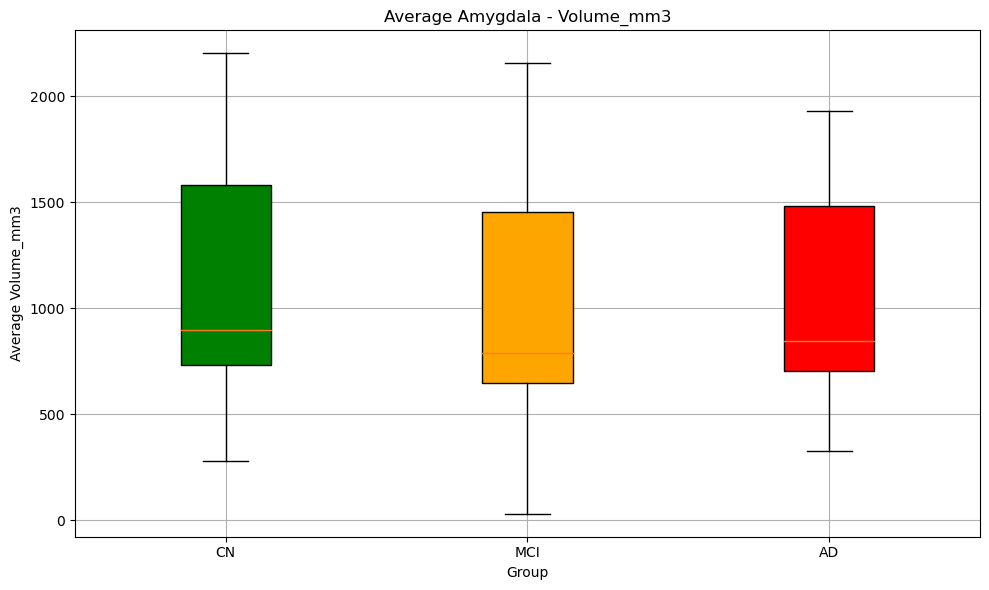

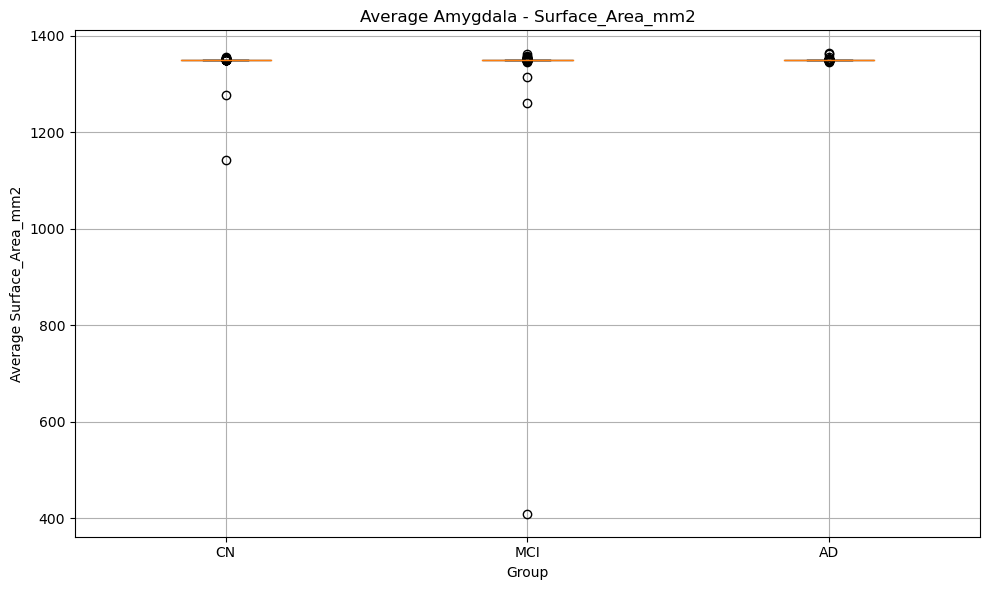

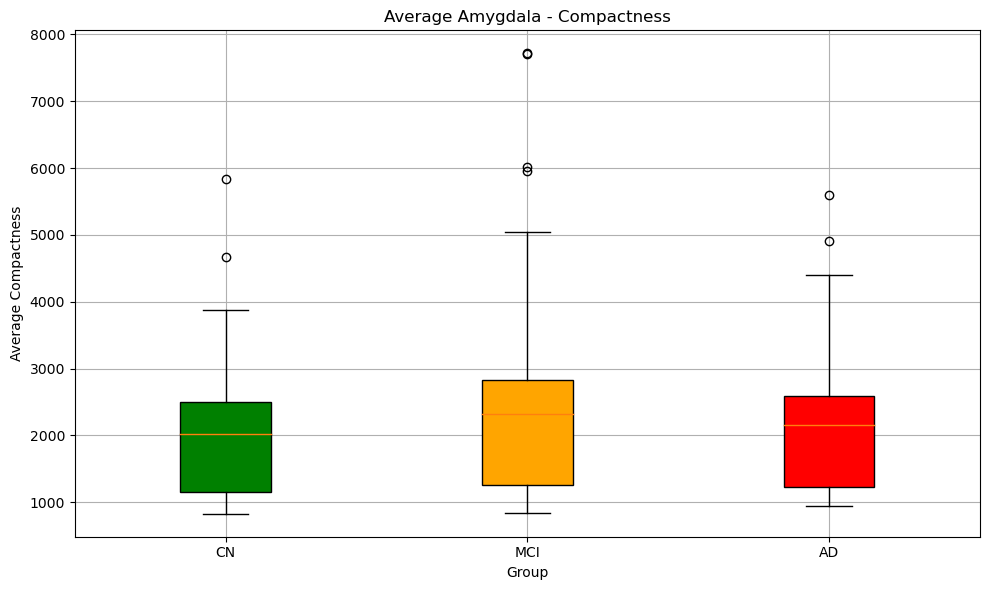

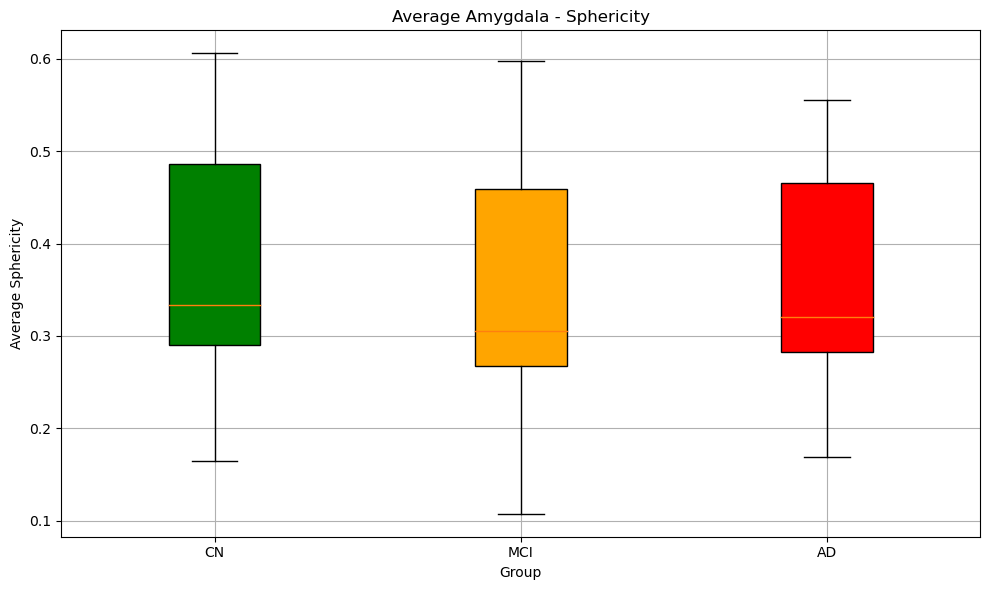

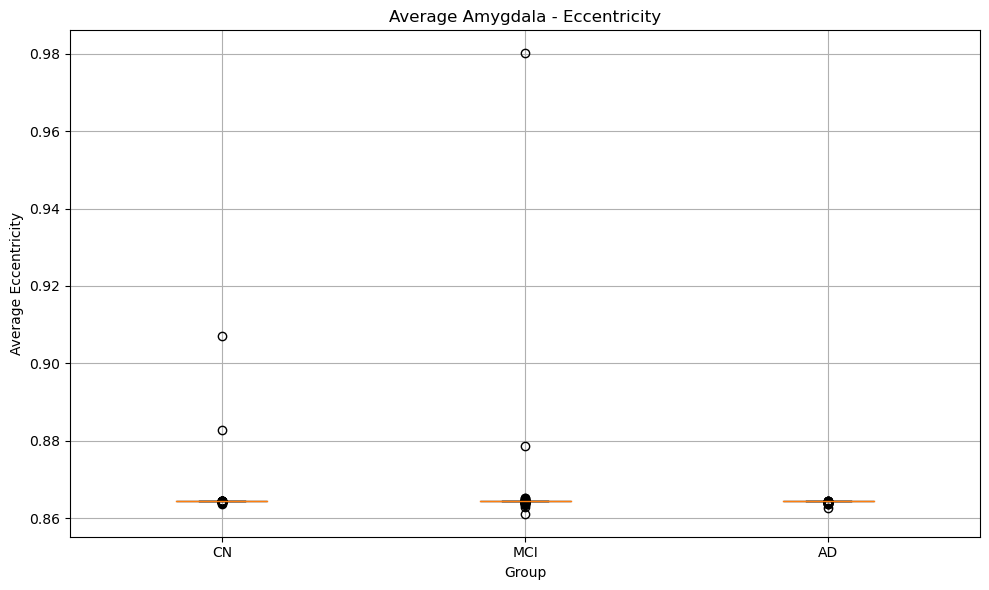

In [28]:
plot_brain_part_features(csv_file, 'amygdala', 'Average Amygdala')

### Lateral Ventricle Features

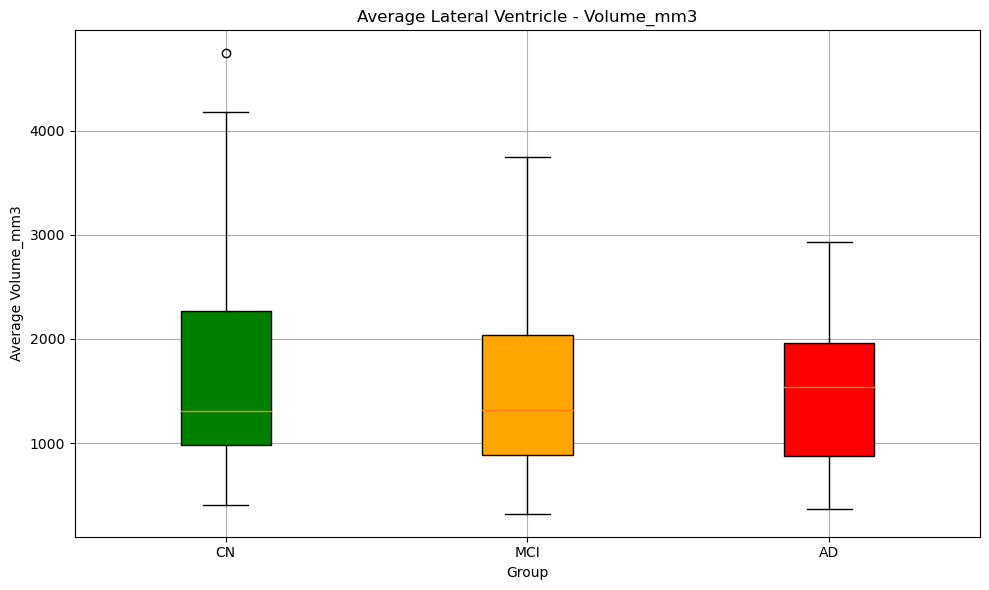

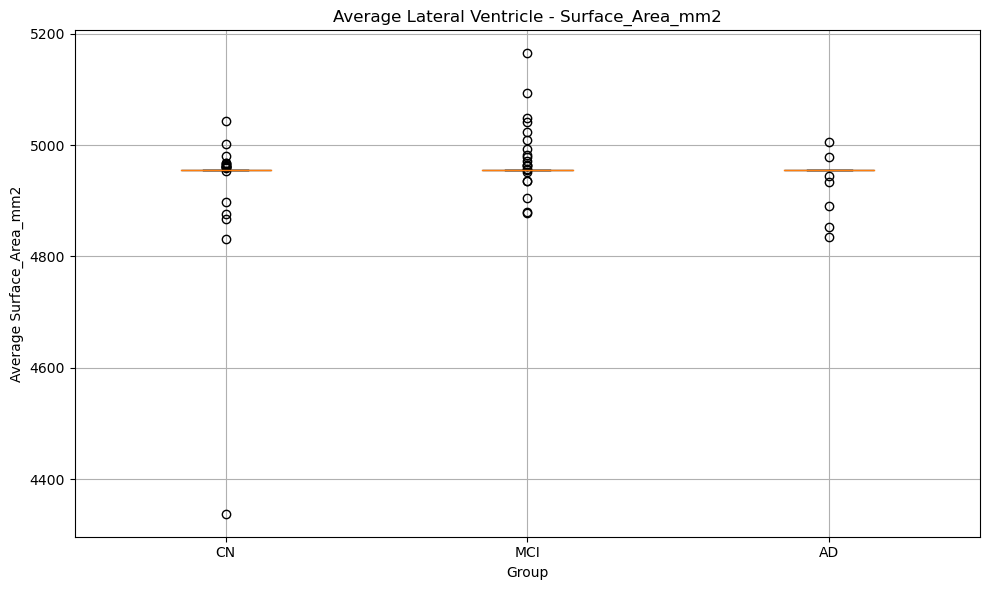

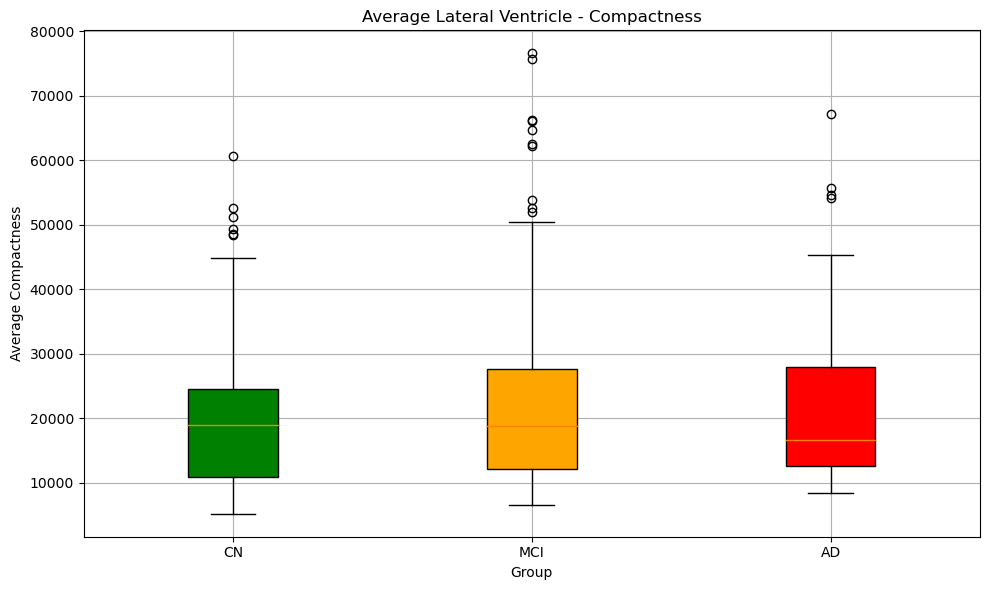

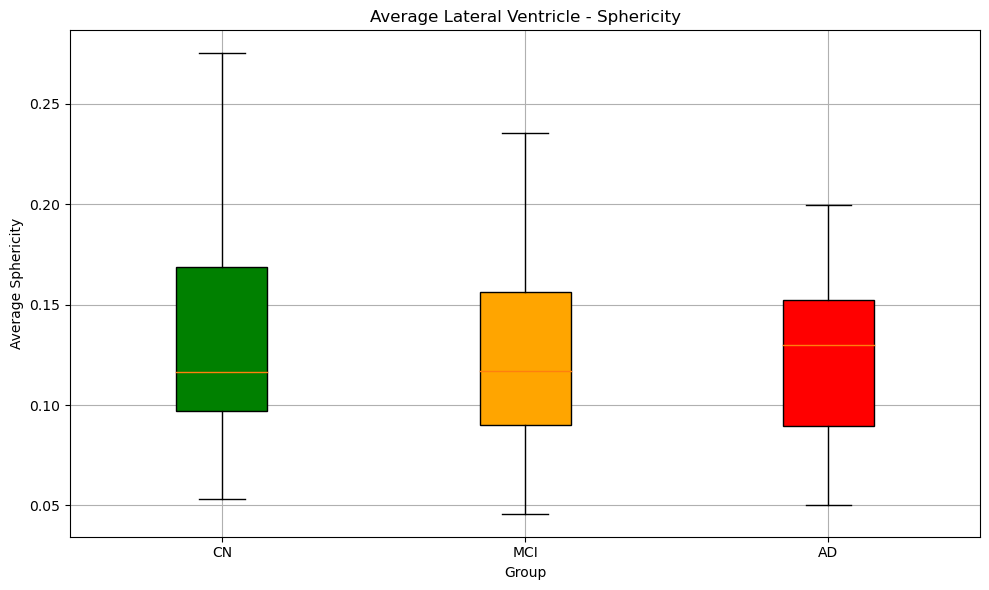

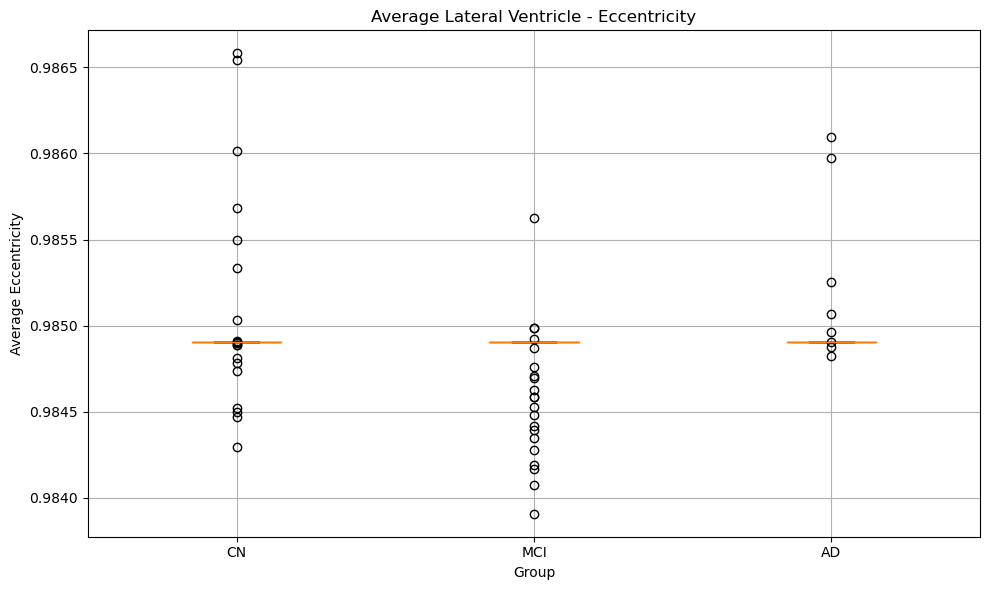

In [29]:
plot_brain_part_features(csv_file, 'lateral_ventricle', 'Average Lateral Ventricle')

### Merge csv

In [12]:

file_path = '/Users/mohidaligill/Documents/Alzheimers/features_merged.csv'
features_df = pd.read_csv(file_path)

# Create new features by averaging left and right structures

features_df['Hippocampus_Volume'] = (features_df['left_hippocampus_Volume_mm3'] + features_df['right_hippocampus_Volume_mm3']) / 2
features_df['Hippocampus_Compactness'] = (features_df['left_hippocampus_Compactness'] + features_df['right_hippocampus_Compactness']) / 2
features_df['Hippocampus_Sphericity'] = (features_df['left_hippocampus_Sphericity'] + features_df['right_hippocampus_Sphericity']) / 2

features_df['Hippocampus_Volume_Ratio'] = (features_df['left_hippocampus_Volume_mm3'] / features_df['right_hippocampus_Volume_mm3'])
features_df['Hippocampus_Compactness_Ratio'] = (features_df['left_hippocampus_Compactness'] / features_df['right_hippocampus_Compactness'])
features_df['Hippocampus_Sphericity_Ratio'] = (features_df['left_hippocampus_Sphericity'] / features_df['right_hippocampus_Sphericity'])

features_df['Cortex_Volume'] = (features_df['left_cortex_Volume_mm3'] + features_df['right_cortex_Volume_mm3']) / 2
features_df['Cortex_Compactness'] = (features_df['left_cortex_Compactness'] + features_df['right_cortex_Compactness']) / 2
features_df['Cortex_Sphericity'] = (features_df['left_cortex_Sphericity'] + features_df['right_cortex_Sphericity']) / 2

features_df['Cortex_Volume_Ratio'] = (features_df['left_cortex_Volume_mm3'] / features_df['right_cortex_Volume_mm3'])
features_df['Cortex_Compactness_Ratio'] = (features_df['left_cortex_Compactness'] / features_df['right_cortex_Compactness'])
features_df['Cortex_Sphericity_Ratio'] = (features_df['left_cortex_Sphericity'] / features_df['right_cortex_Sphericity'])

features_df['Amygdala_Volume'] = (features_df['left_amygdala_Volume_mm3'] + features_df['right_amygdala_Volume_mm3']) / 2
features_df['Amygdala_Compactness'] = (features_df['left_amygdala_Compactness'] + features_df['right_amygdala_Compactness']) / 2
features_df['Amygdala_Sphericity'] = (features_df['left_amygdala_Sphericity'] + features_df['right_amygdala_Sphericity']) / 2

features_df['Amygdala_Volume_Ratio'] = (features_df['left_amygdala_Volume_mm3'] / features_df['right_amygdala_Volume_mm3'])
features_df['Amygdala_Compactness_Ratio'] = (features_df['left_amygdala_Compactness'] / features_df['right_amygdala_Compactness'])
features_df['Amygdala_Sphericity_Ratio'] = (features_df['left_amygdala_Sphericity'] / features_df['right_amygdala_Sphericity'])

features_df['Lateral_ventricle_Volume'] = (features_df['left_lateral_ventricle_Volume_mm3'] + features_df['right_lateral_ventricle_Volume_mm3']) / 2
features_df['Lateral_ventricle_Compactness'] = (features_df['left_lateral_ventricle_Compactness'] + features_df['right_lateral_ventricle_Compactness']) / 2
features_df['Lateral_ventricle_Sphericity'] = (features_df['left_lateral_ventricle_Sphericity'] + features_df['right_lateral_ventricle_Sphericity']) / 2

features_df['Lateral_ventricle_Volume_Ratio'] = (features_df['left_lateral_ventricle_Volume_mm3'] / features_df['right_lateral_ventricle_Volume_mm3'])
features_df['Lateral_ventricle_Compactness_Ratio'] = (features_df['left_lateral_ventricle_Compactness'] / features_df['right_lateral_ventricle_Compactness'])
features_df['Lateral_ventricle_Sphericity_Ratio'] = (features_df['left_lateral_ventricle_Sphericity'] / features_df['right_lateral_ventricle_Sphericity'])



# Select the final set of features for modeling
final_features = ['Hippocampus_Volume',
                  'Hippocampus_Compactness',
                  'Hippocampus_Sphericity',
                  'Cortex_Volume',
                  'Cortex_Compactness',
                  'Cortex_Sphericity',
                  'Amygdala_Volume',
                  'Amygdala_Compactness',
                  'Amygdala_Sphericity',
                  'Lateral_ventricle_Volume',
                  'Lateral_ventricle_Compactness',
                  'Lateral_ventricle_Sphericity',
                  'Hippocampus_Volume_Ratio',
                  'Hippocampus_Compactness_Ratio',
                  'Hippocampus_Sphericity_Ratio',
                  'Cortex_Volume_Ratio',
                  'Cortex_Compactness_Ratio',
                  'Cortex_Sphericity_Ratio',
                  'Amygdala_Volume_Ratio',
                  'Amygdala_Compactness_Ratio',
                  'Amygdala_Sphericity_Ratio',
                  'Lateral_ventricle_Volume_Ratio',
                  'Lateral_ventricle_Compactness_Ratio',
                  'Lateral_ventricle_Sphericity_Ratio',
                  'Group',
                  ]

# Create the final dataframe with selected features
final_df = features_df[final_features]

# Save the final features to a new CSV
final_df.to_csv('/Users/mohidaligill/Documents/Alzheimers/final_selected_features.csv', index=False)

## Feature Reduction

In [13]:
csv_file_path = '/Users/mohidaligill/Documents/Alzheimers/final_selected_features.csv'
data = pd.read_csv(csv_file_path)

In [14]:
X = data.drop(columns=['Group'])
y = data['Group']    

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(solver='saga', max_iter=1000)
rfe = RFE(model, n_features_to_select=1)  # Set to 1 to rank all features
rfe.fit(X_scaled, y)

feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_
})

feature_ranking = feature_ranking.sort_values(by='Ranking')

print("Feature Ranking for Reduction:")
print(feature_ranking)

Feature Ranking for Reduction:
                                Feature  Ranking
2                Hippocampus_Sphericity        1
3                         Cortex_Volume        2
5                     Cortex_Sphericity        3
6                       Amygdala_Volume        4
22  Lateral_ventricle_Compactness_Ratio        5
23   Lateral_ventricle_Sphericity_Ratio        6
16             Cortex_Compactness_Ratio        7
15                  Cortex_Volume_Ratio        8
0                    Hippocampus_Volume        9
1               Hippocampus_Compactness       10
4                    Cortex_Compactness       11
14         Hippocampus_Sphericity_Ratio       12
12             Hippocampus_Volume_Ratio       13
8                   Amygdala_Sphericity       14
13        Hippocampus_Compactness_Ratio       15
18                Amygdala_Volume_Ratio       16
19           Amygdala_Compactness_Ratio       17
20            Amygdala_Sphericity_Ratio       18
17              Cortex_Sphericity_Rati

### Leave only top 6 features in the final selected csv

In [15]:
columns_to_keep = [
    'Hippocampus_Sphericity', 
    'Cortex_Volume', 
    'Cortex_Sphericity', 
    'Lateral_ventricle_Compactness_Ratio', 
    'Lateral_ventricle_Sphericity_Ratio', 
    'Amygdala_Volume', 
    'Group'
]

columns_to_keep_2 = [
    'Hippocampus_Sphericity',
    'Cortex_Volume',
    'Hippocampus_Volume',
    'Cortex_Sphericity',
    'Amygdala_Volume',
    'Hippocampus_Compactness',
    'Group'
]

data_selected = data[columns_to_keep]

data_selected.to_csv(csv_file_path, index=False)

print("Reduced Data:")
print(data_selected.head())

Reduced Data:
   Hippocampus_Sphericity  Cortex_Volume  Cortex_Sphericity  \
0                0.379145  326728.522632           0.216143   
1                0.227209  138093.510263           0.122801   
2                0.197369   97948.610952           0.099796   
3                0.425789  265338.148236           0.189246   
4                0.237869  145343.571036           0.125424   

   Lateral_ventricle_Compactness_Ratio  Lateral_ventricle_Sphericity_Ratio  \
0                             1.064356                            0.979496   
1                             0.962943                            1.047114   
2                             1.099708                            0.958391   
3                             1.018637                            1.008590   
4                             1.029237                            1.001653   

   Amygdala_Volume  Group  
0      1609.539697      1  
1       733.161395      2  
2       516.236052      1  
3      1572.084588      0 

## Model Training

In [3]:
data = pd.read_csv('/Users/muneebamer/Documents/Alzheimers/Alzheimers_Clinical/final_selected_features.csv')

In [5]:
X = data.drop(columns=['Group'])
y = data['Group']

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
adasyn = ADASYN(sampling_strategy='minority')
X_resampled, y_resampled = adasyn.fit_resample(X_scaled, y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [13]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

### CNN with K fold validation

In [45]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report
import torch.nn.functional as F

# Split features and labels
X = data.drop(columns=['Group'])
y = data['Group']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply ADASYN for oversampling to handle class imbalance
adasyn = ADASYN(sampling_strategy='minority')
X_resampled, y_resampled = adasyn.fit_resample(X_scaled, y)

# Convert resampled data to PyTorch tensors
X_resampled_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled_tensor = torch.tensor(y_resampled.values, dtype=torch.long)

# Define the neural network architecture
class ComplexNeuralNet(nn.Module):
    def __init__(self, input_size):
        super(ComplexNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer with 128 neurons
        self.fc2 = nn.Linear(128, 64)          # Second hidden layer with 64 neurons
        self.fc3 = nn.Linear(64, 32)           # Third hidden layer with 32 neurons
        self.fc4 = nn.Linear(32, 16)           # Fourth hidden layer with 16 neurons
        self.out = nn.Linear(16, 3)            # Output layer for 3 classes
        
        # Dropout layers to prevent overfitting
        self.dropout1 = nn.Dropout(0.3)  # Dropout after the first hidden layer
        self.dropout2 = nn.Dropout(0.3)  # Dropout after the second hidden layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)       # No activation function on output layer (CrossEntropy will handle it)
        return x

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_index, val_index in kf.split(X_resampled_tensor):
    # Split the data into training and validation sets
    X_train, X_val = X_resampled_tensor[train_index], X_resampled_tensor[val_index]
    y_train, y_val = y_resampled_tensor[train_index], y_resampled_tensor[val_index]

    # Initialize model, optimizer, and criterion
    input_size = X_train.shape[1]
    model = ComplexNeuralNet(input_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Class weights to handle imbalanced data (optional)
    class_weights = torch.tensor([1.5, 1.8, 2.0])  # Fine-tuning the weights to balance between CN, MCI, and AD
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Training the model for each fold
    epochs = 100
    batch_size = 16

    for epoch in range(epochs):
        model.train()
        
        # Train in batches
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f'Fold {fold}, Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    # Validation after training each fold
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        _, val_predicted = torch.max(val_outputs, 1)
    
    # Generate a classification report for each fold
    print(f"\nClassification Report for Fold {fold}:")
    print(classification_report(y_val, val_predicted, target_names=['CN', 'MCI', 'AD']))

    fold += 1

Fold 1, Epoch [10/100], Loss: 0.9509
Fold 1, Epoch [20/100], Loss: 0.9738
Fold 1, Epoch [30/100], Loss: 0.8868
Fold 1, Epoch [40/100], Loss: 0.9637
Fold 1, Epoch [50/100], Loss: 0.8880
Fold 1, Epoch [60/100], Loss: 0.8221
Fold 1, Epoch [70/100], Loss: 0.8665
Fold 1, Epoch [80/100], Loss: 0.6766
Fold 1, Epoch [90/100], Loss: 0.6685
Fold 1, Epoch [100/100], Loss: 0.7047

Classification Report for Fold 1:
              precision    recall  f1-score   support

          CN       0.54      0.16      0.25        43
         MCI       0.41      0.50      0.45        48
          AD       0.45      0.62      0.52        48

    accuracy                           0.44       139
   macro avg       0.46      0.43      0.41       139
weighted avg       0.46      0.44      0.41       139

Fold 2, Epoch [10/100], Loss: 0.9563
Fold 2, Epoch [20/100], Loss: 0.9699
Fold 2, Epoch [30/100], Loss: 0.9814
Fold 2, Epoch [40/100], Loss: 0.9568
Fold 2, Epoch [50/100], Loss: 0.9394
Fold 2, Epoch [60/100], Loss

## XG Boost

In [23]:
# Load the CSV file
data = pd.read_csv('/Users/muneebamer/Documents/Alzheimers/Alzheimers_Clinical/final_selected_features.csv')

# Separate features and target
X = data.drop('Group', axis=1)
y = data['Group']

# Apply ADASYN to handle class imbalance
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
}

# Set up the Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a variable to track fold number
fold = 1

# Perform grid search with cross-validation
for train_index, val_index in skf.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
    y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]
    
    # Fit the model on the training data
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               scoring='accuracy', cv=skf, verbose=1, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Predict on the validation data
    val_predicted = best_model.predict(X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, val_predicted)
    print(f"\nAccuracy for Fold {fold}: {accuracy * 100:.2f}%")
    
    # Generate and print the classification report
    print(f"\nClassification Report for Fold {fold}:")
    print(classification_report(y_val, val_predicted, target_names=['CN', 'MCI', 'AD']))
    
    fold += 1

Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Accuracy for Fold 1: 63.52%

Classification Report for Fold 1:
              precision    recall  f1-score   support

          CN       0.61      0.53      0.57        51
         MCI       0.59      0.57      0.58        53
          AD       0.69      0.80      0.74        55

    accuracy                           0.64       159
   macro avg       0.63      0.63      0.63       159
weighted avg       0.63      0.64      0.63       159

Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Accuracy for Fold 2: 61.39%

Classification Report for Fold 2:
              precision    recall  f1-score   support

          CN       0.57      0.61      0.59        51
         MCI       0.64      0.51      0.57        53
          AD       0.63      0.72      0.67        54

    accuracy                           0.61       158
   macro avg       0.62      0.61      0.61       158
weighted avg       0.62      0.61    

## Graphic Card Used

2 x NVIDIA RTX A4000 with 16Gb of VRam

Multi processing used on GPU and CPUs

## U-Net model

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import nibabel as nib
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import torchio as tio
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

augmentation_pipeline = tio.Compose([
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=5),
    tio.RandomFlip(axes=(0, 1, 2)),
    tio.OneOf({
        tio.RandomMotion(p=0.2): 0.1,  # Adjust probabilities based on class
        tio.RandomNoise(p=0.2): 0.1,
        tio.RandomBiasField(p=0.2): 0.1  # Add more types of augmentations
    }),
    tio.RescaleIntensity((-1, 1))  # Ensure normalization is consistent
])

# Utility function to load and check MRI dimensions and channels
def load_mri_image_and_check_channels(image_path):
    mri_image = nib.load(image_path)
    mri_image_data = mri_image.get_fdata()
    dimensions = mri_image_data.shape
    return dimensions

# Function to load and normalize MRI images
def load_and_preprocess_mri(image_path):
    mri_image = nib.load(image_path)
    mri_image_data = mri_image.get_fdata()
    mri_image_data = (mri_image_data - np.min(mri_image_data)) / (np.max(mri_image_data) - np.min(mri_image_data))
    mri_image_tensor = torch.tensor(mri_image_data, dtype=torch.float32)
    return mri_image_tensor

class MRIDataset(Dataset):
    def __init__(self, image_dir, mri_to_label, transform=None):
        self.image_dir = image_dir
        self.mri_to_label = mri_to_label
        self.image_ids = [image_id for image_id in mri_to_label.keys() if os.path.exists(os.path.join(image_dir, f"{image_id}.nii"))]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        mri_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, f"{mri_id}.nii")
        image_tensor = load_and_preprocess_mri(image_path)
        label = self.mri_to_label[mri_id]
        label_tensor = torch.tensor(label)

        # Apply augmentations based on class
        if label in [0, 2]:  # Assuming 0 and 2 are minority classes
            subject = tio.Subject(image=tio.ScalarImage(tensor=image_tensor.unsqueeze(0)))  # Add channel dimension
            subject = self.transform(subject)
            image_tensor = subject['image'].tensor.squeeze(0)  # Remove channel dimension after transform

        return image_tensor, label_tensor
    
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNet3D, self).__init__()
        # Reduced number of filters and simplified architecture
        self.enc1 = self.conv_block(in_channels, 16)  # Reduced from 32 filters
        self.enc2 = self.conv_block(16, 32)  # Reduced from 64 filters
        self.enc3 = self.conv_block(32, 64)  # Reduced from 128 filters
        self.enc4 = self.conv_block(64, 128)  # Reduced from 256 filters

        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.bottleneck = self.conv_block(128, 256)  # Bottleneck with reduced filters

        self.upconv4 = self.up_conv(256, 128)
        self.dec4 = self.conv_block(256, 128)
        self.upconv3 = self.up_conv(128, 64)
        self.dec3 = self.conv_block(128, 64)
        self.upconv2 = self.up_conv(64, 32)
        self.dec2 = self.conv_block(64, 32)
        self.upconv1 = self.up_conv(32, 16)
        self.dec1 = self.conv_block(32, 16)

        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Linear(16, out_channels)  # Reduced final layer complexity

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.pad_and_concat(dec4, enc4)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = self.pad_and_concat(dec3, enc3)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = self.pad_and_concat(dec2, enc2)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = self.pad_and_concat(dec1, enc1)
        dec1 = self.dec1(dec1)

        pooled = self.global_pool(dec1)
        flattened = pooled.view(pooled.size(0), -1)
        out = self.fc(flattened)

        return out

    @staticmethod
    def conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(0.2)  # Added dropout to deeper layers
        )

    @staticmethod
    def up_conv(in_channels, out_channels):
        return nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)

    @staticmethod
    def pad_and_concat(dec_tensor, enc_tensor):
        # Existing padding logic remains the same
        diffZ = enc_tensor.size(2) - dec_tensor.size(2)
        diffY = enc_tensor.size(3) - dec_tensor.size(3)
        diffX = enc_tensor.size(4) - dec_tensor.size(4)
        dec_tensor_padded = F.pad(dec_tensor, [
            diffX // 2, diffX - diffX // 2,
            diffY // 2, diffY - diffY // 2,
            diffZ // 2, diffZ - diffZ // 2
        ])
        return torch.cat((dec_tensor_padded, enc_tensor), dim=1)    
    
# Function to save the trained model
def save_model(model, path="unet3d_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Function to load the trained model
def load_model(path="unet3d_model.pth"):
    model = UNet3D(in_channels=1, out_channels=3)  # Initialize a new instance of the model
    model.load_state_dict(torch.load(path))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {path}")
    return model

def collate_fn(batch):
    # Filter out any items that are None
    batch = [b for b in batch if b[0] is not None and b[1] is not None]

    if len(batch) == 0:
        return None, None  # Return None if the entire batch is invalid

    images, labels = zip(*batch)

    # Find the maximum dimensions in the batch
    max_depth = max([img.shape[0] for img in images])
    max_height = max([img.shape[1] for img in images])
    max_width = max([img.shape[2] for img in images])

    # Pad each image in the batch to the maximum dimensions
    padded_images = []
    for img in images:
        depth_diff = max_depth - img.shape[0]
        height_diff = max_height - img.shape[1]
        width_diff = max_width - img.shape[2]

        # Apply padding along each dimension (depth, height, width)
        padded_img = F.pad(img, (0, width_diff, 0, height_diff, 0, depth_diff))  # Pads along (W, H, D)
        padded_images.append(padded_img)

    # Stack the images and labels to form a batch
    images_tensor = torch.stack(padded_images)
    labels_tensor = torch.stack(labels)

    return images_tensor, labels_tensor

# Function to evaluate the model
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient computation during inference
        for images, labels in dataloader:
            images = images.unsqueeze(1).to(device)  # Add channel dimension and move to GPU
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class (highest score)
            
            all_preds.extend(preds.cpu().numpy())  # Collect the predictions
            all_labels.extend(labels.cpu().numpy())  # Collect the ground truth labels
    
    return all_preds, all_labels

# Calculate metrics from predictions and labels
def calculate_metrics(preds, labels):
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=1)
    recall = recall_score(labels, preds, average='weighted', zero_division=1)
    f1 = f1_score(labels, preds, average='weighted', zero_division=1)
    cm = confusion_matrix(labels, preds)
    class_report = classification_report(labels, preds)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(class_report)

# Function to create dataloader
def create_dataloader(image_dir, label_file_path, batch_size=2):
    df_labels = pd.read_csv(label_file_path)
    mri_to_label = {row['MRI_ID']: row['Group'] for _, row in df_labels.iterrows()}
    
    # Instantiate the dataset with transformations
    dataset = MRIDataset(image_dir, mri_to_label, transform=augmentation_pipeline)
    dataloader = DataLoader(dataset, batch_size, shuffle=True, collate_fn=collate_fn)
    return dataloader


# Function to calculate class weights
def calculate_class_weights(class_counts):
    total_samples = sum(class_counts.values())
    return {label: total_samples / count for label, count in class_counts.items()}

# Initialize the gradient scaler for mixed precision

# Add this function anywhere before you use it
def check_class_distribution(dataloader):
    class_counts = {0: 0, 1: 0, 2: 0}  # Assuming 3 classes: CN (0), MCI (1), AD (2)
    
    for images, labels in dataloader:
        unique, counts = torch.unique(labels, return_counts=True)
        for u, c in zip(unique.cpu().numpy(), counts.cpu().numpy()):
            class_counts[int(u)] += c
    return class_counts

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # You might want to increase alpha for minority classes.
        self.gamma = gamma  # Increasing gamma makes the loss focus more on hard-to-classify examples.
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
        
    def __init__(self, alpha=1, gamma=2, weights=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weights = weights
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weights)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

scaler = GradScaler(device='cuda')

def train_model(model, dataloader, criterion, optimizer, device, num_epochs=10, max_grad_norm=1.0):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_preds = []
        epoch_labels = []
        
        for images, labels in dataloader:
            images = images.unsqueeze(1).to(device)  # Add channel dimension (1) and move to the correct device
            labels = labels.to(device)  # Move labels to the correct device

            optimizer.zero_grad()  # Zero the gradients

            # Mixed precision forward pass (optional)
            with autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backward pass
            scaler.scale(loss).backward()

            # Gradient clipping
            scaler.unscale_(optimizer)  # Unscale gradients before clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Clip gradients

            # Optimizer step
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            epoch_preds.extend(preds.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())

        if (epoch % 5) == 0:
            # Print epoch loss and class predictions
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")
            print("Predicted class distribution in the current epoch:")
            print(np.bincount(epoch_preds, minlength=3))  # Assuming 3 classes (0, 1, 2)
            print("True class distribution in the current epoch:")
            print(np.bincount(epoch_labels, minlength=3))

        torch.cuda.empty_cache()  # Free up GPU memory after each epoch


if __name__ == "__main__":
    # Define paths
    image_dir = "/db/proj-mag/segmented_1"
    csv_path = "/db/proj-mag/Label_File.csv"
    
    # Create the dataloader
    dataloader = create_dataloader(image_dir, csv_path)

    # Check class distribution and calculate class weights
    class_counts = check_class_distribution(dataloader)
    class_weights = calculate_class_weights(class_counts)
    weights = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32)

    # Set device and instantiate model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet3D(in_channels=1, out_channels=3)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device)

    # Define the loss function and optimizer
    weights_tensor = torch.tensor([class_weights[i] for i in sorted(class_weights)], dtype=torch.float32).to(device)
    criterion = FocalLoss(alpha=1, gamma=2, weights=weights_tensor)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    # Train the model
    num_epochs = 30
    train_model(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the trained model
    save_model(model, path=r"unet3d_model_1.pth")
 
    # Evaluate the model
    preds, labels = evaluate_model(model, dataloader, device)
    calculate_metrics(preds, labels)

    # Optional: Inspect predictions on a small batch
    images, labels = next(iter(dataloader))
    images, labels = images.unsqueeze(1).to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        print("Predictions:", preds.cpu().numpy())
        print("Actual Labels:", labels.cpu().numpy())

The U-Net did not perform very well as the model had a lot of parameters and would use 14gb of vram out of 16gb with batch size 1,
Can mention loss of gradient as batch size is only 1,
Would crash if batch size increased,
Training times were too high even on the GPU,

Results I will share in a bit

## DenseNet3D

A DenseNet network was developed

Performed much better than the U-Net model

Each image would take 3gb of Vram so batch size increased to 10

FocalLoss used to balance classes

Extreme Image Augmentations performed on minority classes and simpler augmentation on the majority class

Hyper parameter tuning performed to find the perfect value of alpha and gamma

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import nibabel as nib
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import torchio as tio
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

augmentation_pipeline = tio.Compose([
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=5),
    tio.RandomFlip(axes=(0, 1, 2)),
    tio.OneOf({
        tio.RandomMotion(p=0.2): 0.1,  # Adjust probabilities based on class
        tio.RandomNoise(p=0.2): 0.1,
        tio.RandomBiasField(p=0.2): 0.1  # Add more types of augmentations
    }),
    tio.RescaleIntensity((-1, 1))  # Ensure normalization is consistent
])

lighter_transforms = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2)),  # Flip images randomly across all axes
    tio.RescaleIntensity((-1, 1)),   # Normalize intensity
    tio.RandomAffine(scales=(0.95, 1.05), degrees=5, translation=2),  # Less aggressive affine transformations
    tio.OneOf({
        tio.RandomNoise(p=0.1): 0.6,  # Lower impact and probability
        tio.RandomBiasField(p=0.1): 0.4
    })
])

# Function to load and normalize MRI images
def load_and_preprocess_mri(image_path):
    mri_image = nib.load(image_path)
    mri_image_data = mri_image.get_fdata()
    mri_image_data = (mri_image_data - np.min(mri_image_data)) / (np.max(mri_image_data) - np.min(mri_image_data))
    mri_image_tensor = torch.tensor(mri_image_data, dtype=torch.float32)
    return mri_image_tensor

class MRIDataset(Dataset):
    def __init__(self, image_dir, mri_to_label, transform=None, light_transform=None):
        self.image_dir = image_dir
        self.mri_to_label = mri_to_label
        self.image_ids = [image_id for image_id in mri_to_label.keys() if os.path.exists(os.path.join(image_dir, f"{image_id}.nii.gz"))]
        self.transform = transform
        self.light_transform = light_transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        mri_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, f"{mri_id}.nii.gz")
        image_tensor = load_and_preprocess_mri(image_path)
        label = self.mri_to_label[mri_id]
        label_tensor = torch.tensor(label)

        # Apply augmentations based on class
        if label in [0, 2]:  # Assuming 0 and 2 are minority classes
            subject = tio.Subject(image=tio.ScalarImage(tensor=image_tensor.unsqueeze(0)))  # Add channel dimension
            subject = self.transform(subject)
            image_tensor = subject['image'].tensor.squeeze(0)  # Remove channel dimension after transform
            
        if label in [1]:  # Assuming 0 and 2 are majority classes
            subject = tio.Subject(image=tio.ScalarImage(tensor=image_tensor.unsqueeze(0)))  # Add channel dimension
            subject = self.light_transform(subject)
            image_tensor = subject['image'].tensor.squeeze(0)  # Remove channel dimension after transform

        return image_tensor, label_tensor

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm3d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1', nn.Conv3d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False))
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv3d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False))

        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm3d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv3d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))

class DenseNet3D(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, bn_size=4, drop_rate=0, num_classes=3):
        super(DenseNet3D, self).__init__()

        # First convolution
        self.features = nn.Sequential(
            nn.Conv3d(1, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm3d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        )

        # Each dense block
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate

            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm3d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool3d(out, (1, 1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

# Function to save the trained model
def save_model(model, path="DenseNet3D_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Function to load the trained model
def load_model(path="DenseNet3D_model.pth"):
    model = DenseNet3D()  # Initialize a new instance of the model
    model.load_state_dict(torch.load(path))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {path}")
    return model

def collate_fn(batch):
    # Filter out any items that are None
    batch = [b for b in batch if b[0] is not None and b[1] is not None]

    if len(batch) == 0:
        return None, None  # Return None if the entire batch is invalid

    images, labels = zip(*batch)

    # Find the maximum dimensions in the batch
    max_depth = max([img.shape[0] for img in images])
    max_height = max([img.shape[1] for img in images])
    max_width = max([img.shape[2] for img in images])

    # Pad each image in the batch to the maximum dimensions
    padded_images = []
    for img in images:
        depth_diff = max_depth - img.shape[0]
        height_diff = max_height - img.shape[1]
        width_diff = max_width - img.shape[2]

        # Apply padding along each dimension (depth, height, width)
        padded_img = F.pad(img, (0, width_diff, 0, height_diff, 0, depth_diff))  # Pads along (W, H, D)
        padded_images.append(padded_img)

    # Stack the images and labels to form a batch
    images_tensor = torch.stack(padded_images)
    labels_tensor = torch.stack(labels)

    return images_tensor, labels_tensor

# Function to evaluate the model
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient computation during inference
        for images, labels in dataloader:
            images = images.unsqueeze(1).to(device)  # Add channel dimension and move to GPU
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class (highest score)
            
            all_preds.extend(preds.cpu().numpy())  # Collect the predictions
            all_labels.extend(labels.cpu().numpy())  # Collect the ground truth labels
    
    return all_preds, all_labels

# Calculate metrics from predictions and labels
def calculate_metrics(preds, labels):
    try:
        acc = accuracy_score(labels, preds)
        precision = precision_score(labels, preds, average='weighted', zero_division=1)
        recall = recall_score(labels, preds, average='weighted', zero_division=1)
        f1 = f1_score(labels, preds, average='weighted', zero_division=1)
        cm = confusion_matrix(labels, preds)
        class_report = classification_report(labels, preds)
        
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("Confusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(class_report)
        
        return acc, precision, recall, f1
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return 0, 0, 0, 0  # Return zero or a default value for all metrics
    
# Function to create dataloader
def create_dataloader(image_dir, label_file_path, batch_size=10):
    df_labels = pd.read_csv(label_file_path)
    mri_to_label = {row['MRI_ID']: row['Group'] for _, row in df_labels.iterrows()}
    
    # Instantiate the dataset with transformations
    dataset = MRIDataset(image_dir, mri_to_label, transform=augmentation_pipeline, light_transform=lighter_transforms)
    dataloader = DataLoader(dataset, batch_size, shuffle=True, collate_fn=collate_fn, num_workers=8)
    return dataloader

# Initialize the gradient scaler for mixed precision

# Add this function anywhere before you use it
def check_class_distribution(dataloader):
    class_counts = {0: 0, 1: 0, 2: 0}  # Assuming 3 classes: CN (0), MCI (1), AD (2)
    
    for images, labels in dataloader:
        unique, counts = torch.unique(labels, return_counts=True)
        for u, c in zip(unique.cpu().numpy(), counts.cpu().numpy()):
            class_counts[int(u)] += c
    return class_counts

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
        
def run_experiments(dataloader, device, alphas, gammas, num_epochs=10):
    results = {}
    for alpha in alphas:
        for gamma in gammas:
            model = DenseNet3D().to(device)
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)
            optimizer = optim.AdamW(model.parameters(), lr=1e-4)
            print(f"Training with alpha: {alpha}, gamma: {gamma}")
            train_model(model, dataloader, optimizer, device, alpha, gamma, num_epochs)
            preds, labels = evaluate_model(model, dataloader, device)
            acc, prec, recall, f1 = calculate_metrics(preds, labels)
            results[(alpha, gamma)] = (acc, prec, recall, f1)
            save_model(model, 'dense_model_1.2_4.pth')
    return results

scaler = GradScaler(device='cuda')

def train_model(model, dataloader, optimizer, device, alpha, gamma, num_epochs=10, max_grad_norm=1.0):
    criterion = FocalLoss(alpha=alpha, gamma=gamma, reduction='mean').to(device)
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_preds = []
        epoch_labels = []
        
        for images, labels in dataloader:
            images = images.unsqueeze(1).to(device)  # Add channel dimension (1) and move to the correct device
            labels = labels.to(device)  # Move labels to the correct device

            optimizer.zero_grad()  # Zero the gradients

            # Mixed precision forward pass (optional)
            with autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backward pass
            scaler.scale(loss).backward()

            # Gradient clipping
            scaler.unscale_(optimizer)  # Unscale gradients before clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Clip gradients

            # Optimizer step
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            epoch_preds.extend(preds.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())

        if (epoch % 5) == 0:
            # Print epoch loss and class predictions
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")
            print("Predicted class distribution in the current epoch:")
            print(np.bincount(epoch_preds, minlength=3))  # Assuming 3 classes (0, 1, 2)
            print("True class distribution in the current epoch:")
            print(np.bincount(epoch_labels, minlength=3))

        torch.cuda.empty_cache()  # Free up GPU memory after each epoch

if __name__ == "__main__":
    image_dir = "/db/proj-mag/final"
    csv_path = "/db/proj-mag/Label_File.csv"
    dataloader = create_dataloader(image_dir, csv_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    alphas = [1.2]
    gammas = [4]
    results = run_experiments(dataloader, device, alphas, gammas, num_epochs=10)
    
    # Print the results for each combination
    for params, metrics in results.items():
        print(f"Alpha: {params[0]}, Gamma: {params[1]} - Metrics: {metrics}")

Training with alpha: 1.2, gamma: 4
/cs/home/psxmg8/miniconda3/envs/mohids-bhowbhow/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Epoch [1/10], Loss: 0.25893444486639716
Predicted class distribution in the current epoch:
[196 321  26]
True class distribution in the current epoch:
[178 267  98]
Epoch [6/10], Loss: 0.22224126918749376
Predicted class distribution in the current epoch:
[170 348  25]
True class distribution in the current epoch:
[178 267  98]
Accuracy: 0.5783
Precision: 0.6167
Recall: 0.5783
F1 Score: 0.5703
Confusion Matrix:
[[ 52  54  72]
 [ 10 213  44]
 [ 19  30  49]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.29      0.40       178
           1       0.72      0.80      0.76       267
           2       0.30      0.50      0.37        98

    accuracy                           0.58       543
   macro avg       0.55      0.53      0.51       543
weighted avg       0.62      0.58      0.57       543

Model saved to dense_model_1.2_4.pth
Alpha: 1.2, Gamma: 4 - Metrics: (0.578268876611418, 0.6166841320923581, 0.578268876611418, 0.5702803434751762)
